In [1]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
import matplotlib
from PIL import Image, ImageOps

matplotlib.rcParams['figure.figsize'] = (11.75, 8.5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Предсказание методом плавающего окна

<class 'numpy.ndarray'>
float64
(937, 1600)


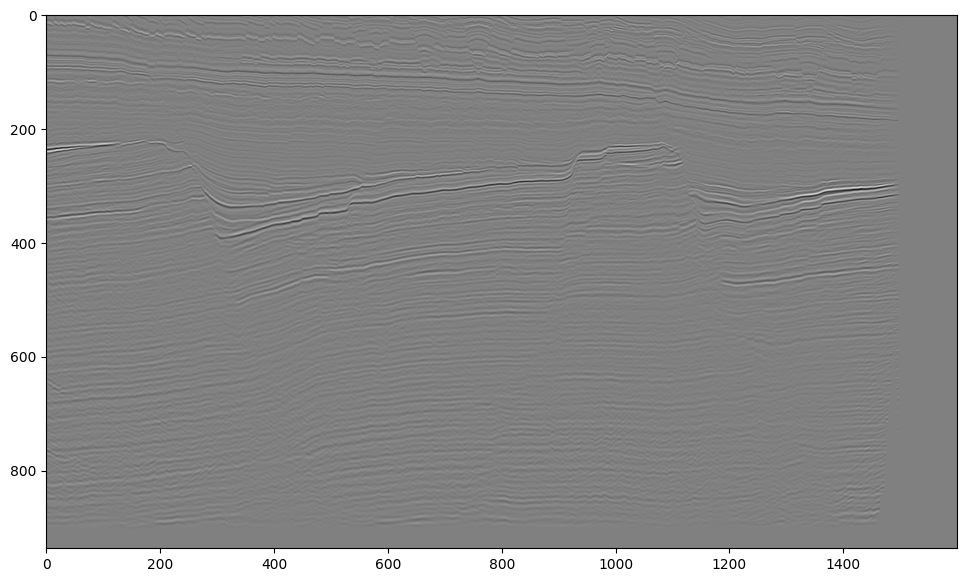

In [2]:
data = np.load("seistrain4.npz")['arr_0']
min_data_value = np.min(data)
max_data_value = np.max(data)
data = (data - min_data_value) / (max_data_value - min_data_value) * 255
data = data[42].T[600:, 400: 2000]
print(type(data))
print(data.dtype)
print(np.shape(data))
fig, ax = plt.subplots()
ax.imshow(data, cmap='gray_r')

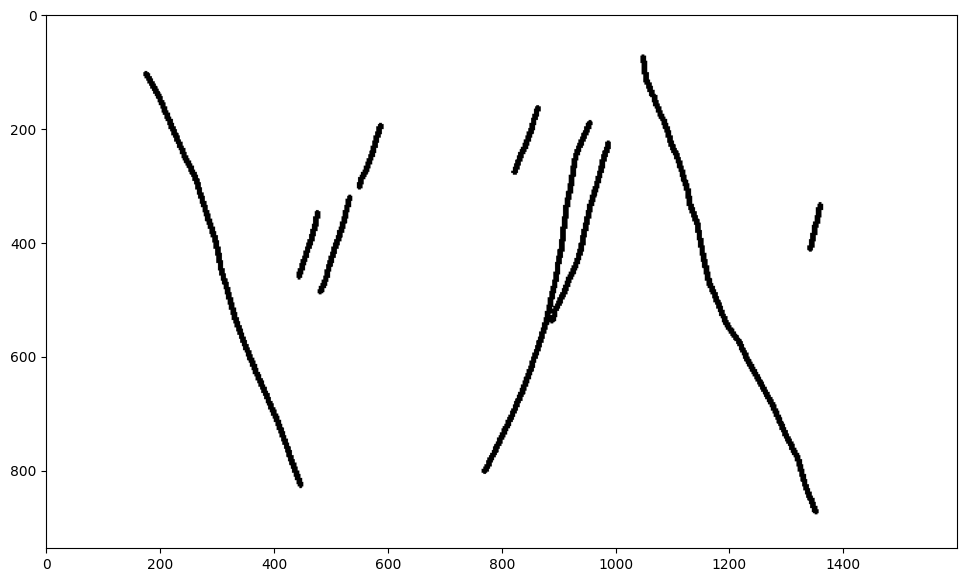

In [3]:
labels = np.load('faulttrain4.npz')['arr_0'][42].T[600:, 400: 2000]
fig, ax = plt.subplots()
ax.imshow(labels, cmap='gray_r')

In [32]:
def get_windows_coords(window_size, figure_size, stride):
    start_coord = 0
    coords_list = []
    while True:
        cur_start_coord = start_coord
        cur_end_coord = cur_start_coord + window_size
        if cur_end_coord > figure_size:
            cur_start_coord -= cur_end_coord - figure_size
            cur_end_coord = cur_start_coord + window_size
        coords_list.append([cur_start_coord, cur_end_coord])
        start_coord += stride
        if cur_end_coord == figure_size:
            return coords_list

WINDOW_SIZE = 256
STRIDE = 16

width_coords = get_windows_coords(window_size=WINDOW_SIZE, figure_size=np.shape(data)[1], stride=STRIDE)
height_coords = get_windows_coords(window_size=WINDOW_SIZE, figure_size=np.shape(data)[0], stride=STRIDE)
print(np.shape(data[height_coords[-1][0]: height_coords[-1][1], width_coords[-1][0]: width_coords[-1][1]]))

In [23]:
THRESHOLD = 0.5
weights_path = 'data/weights/Latest_100epochs_1e-3lr.pth.gz'

predict_array = np.zeros(np.shape(data))
votes_array = np.zeros(np.shape(data))
# подгрузка модели нейросети
network = torchvision.models.segmentation.deeplabv3_resnet50(num_classes=1, aux_loss=True)
network.backbone.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
network.load_state_dict(torch.load(weights_path, map_location=device))
# network = network.to(device)
network.eval()

iterations = 0
total_iterations = len(width_coords) * len(height_coords)
start_time = time.time()
for width in width_coords:
    for height in height_coords:
        img_window = ImageOps.grayscale(Image.fromarray(data[height[0]: height[1], width[0]: width[1]]))
        window = transforms.ToTensor()(img_window)
        window = window[None, :]
        window.to(device)

        output = network(window)['out']
        output = output.squeeze().data.cpu().numpy()

        output[output >= THRESHOLD] = 1
        output[output < THRESHOLD] = 0

        votes_array[height[0]: height[1], width[0]: width[1]] += 1
        for i in range(len(output)):
            for j in range(len(output[i])):
                predict_array[height[0] + i][width[0] + j] += output[i][j]

        iterations += 1
        if iterations % 100 == 0:
            print(f"{iterations} / {total_iterations}")

for i in range(len(predict_array)):
    for j in range(len(predict_array[i])):
        try:
            predict_array[i][j] = predict_array[i][j] / votes_array[i][j]
        except ZeroDivisionError:
            print("ZeroDivisionError")
end_time = time.time()
print(end_time - start_time)

100 / 3740
200 / 3740
300 / 3740
400 / 3740
500 / 3740
600 / 3740
700 / 3740
800 / 3740
900 / 3740
1000 / 3740
1100 / 3740
1200 / 3740
1300 / 3740
1400 / 3740
1500 / 3740
1600 / 3740
1700 / 3740
1800 / 3740
1900 / 3740
2000 / 3740
2100 / 3740
2200 / 3740
2300 / 3740
2400 / 3740
2500 / 3740
2600 / 3740
2700 / 3740
2800 / 3740
2900 / 3740
3000 / 3740
3100 / 3740
3200 / 3740
3300 / 3740
3400 / 3740
3500 / 3740
3600 / 3740
3700 / 3740
1438.3640003204346


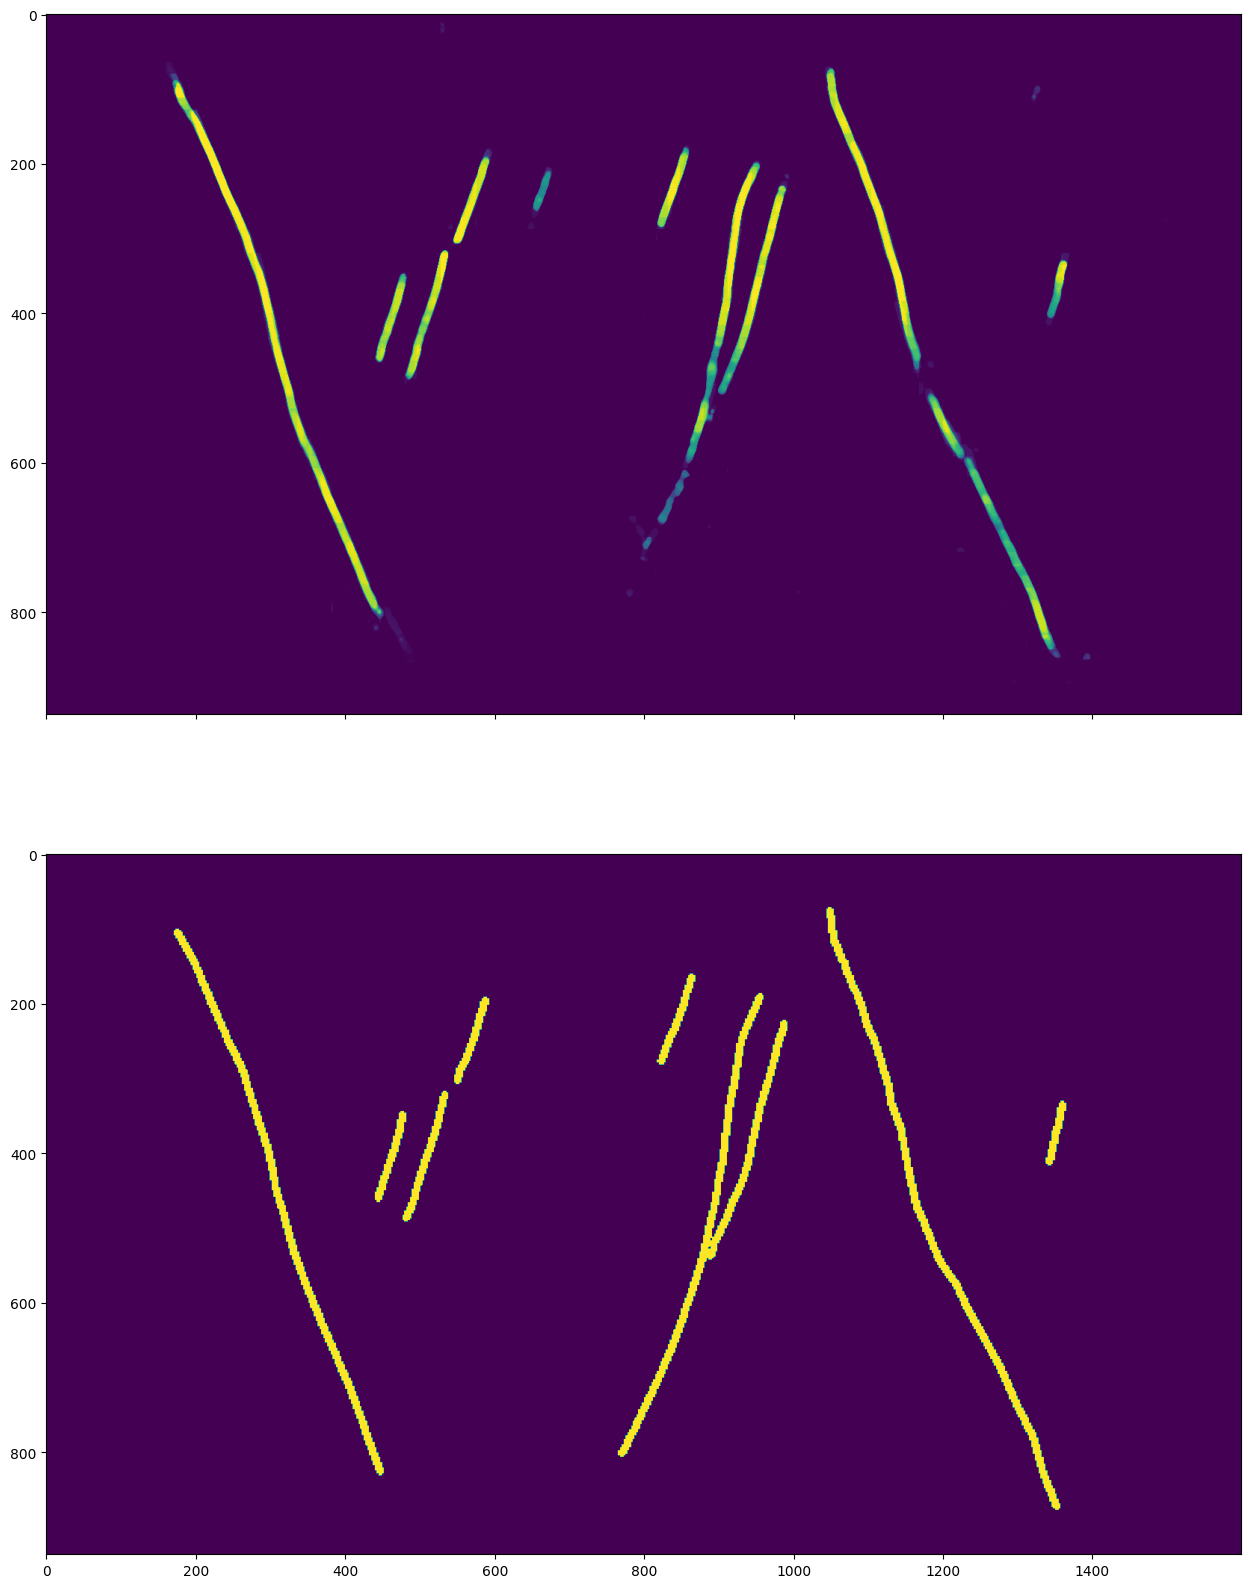

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 20))
ax[0].imshow(predict_array)
ax[1].imshow(labels);

## Предсказание единого изображения

<class 'numpy.ndarray'>
float64
(937, 1600)


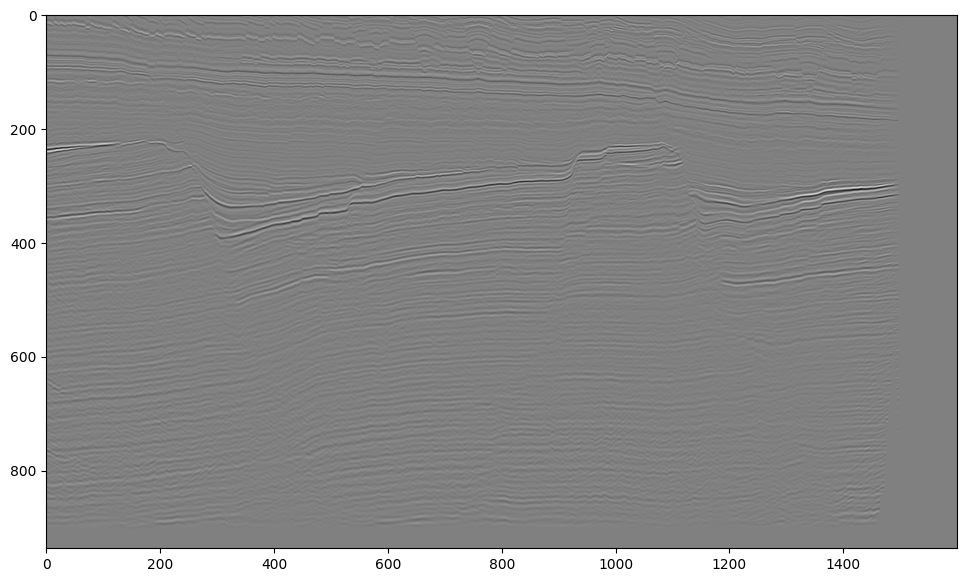

In [9]:
data = np.load("seistrain4.npz")['arr_0']
min_data_value = np.min(data)
max_data_value = np.max(data)
data = (data - min_data_value) / (max_data_value - min_data_value) * 255
data = data[42].T[600:, 400: 2000]
print(type(data))
print(data.dtype)
print(np.shape(data))
fig, ax = plt.subplots()
ax.imshow(data, cmap='gray_r')

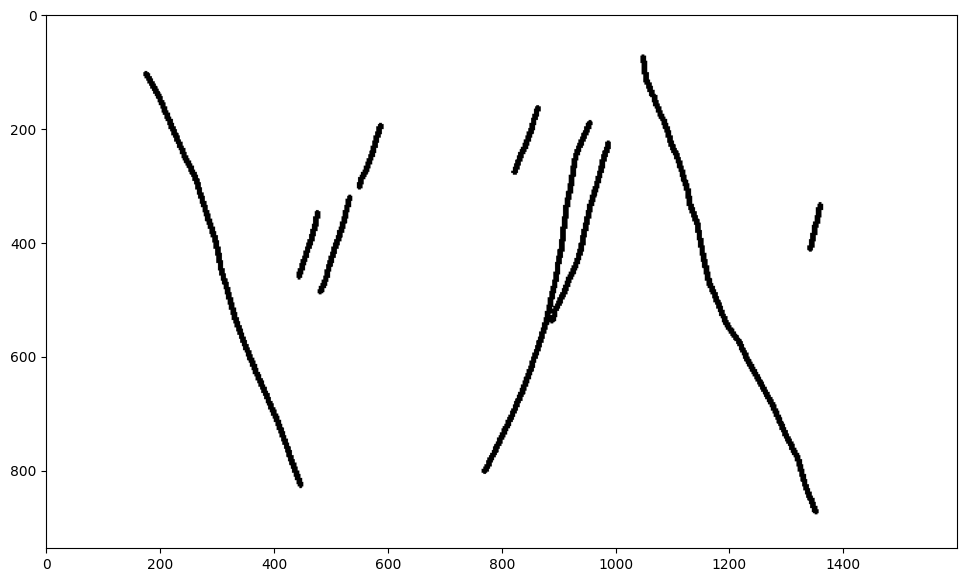

In [10]:
labels = np.load('faulttrain4.npz')['arr_0'][42].T[600:, 400: 2000]
fig, ax = plt.subplots()
ax.imshow(labels, cmap='gray_r')

In [6]:
print(data.shape)
n_rows_to_add = data.shape[1] - data.shape[0]
for i in range(n_rows_to_add):
    data = np.r_[data,[np.zeros(data.shape[1])]]
print(data.shape)
print(labels.shape)
n_rows_to_add = labels.shape[1] - labels.shape[0]
for i in range(n_rows_to_add):
    labels = np.r_[labels,[np.zeros(labels.shape[1])]]
print(labels.shape)

(937, 1600)
(1600, 1600)
(937, 1600)
(1600, 1600)


5.821000337600708
(937, 1600)
(937, 1600)


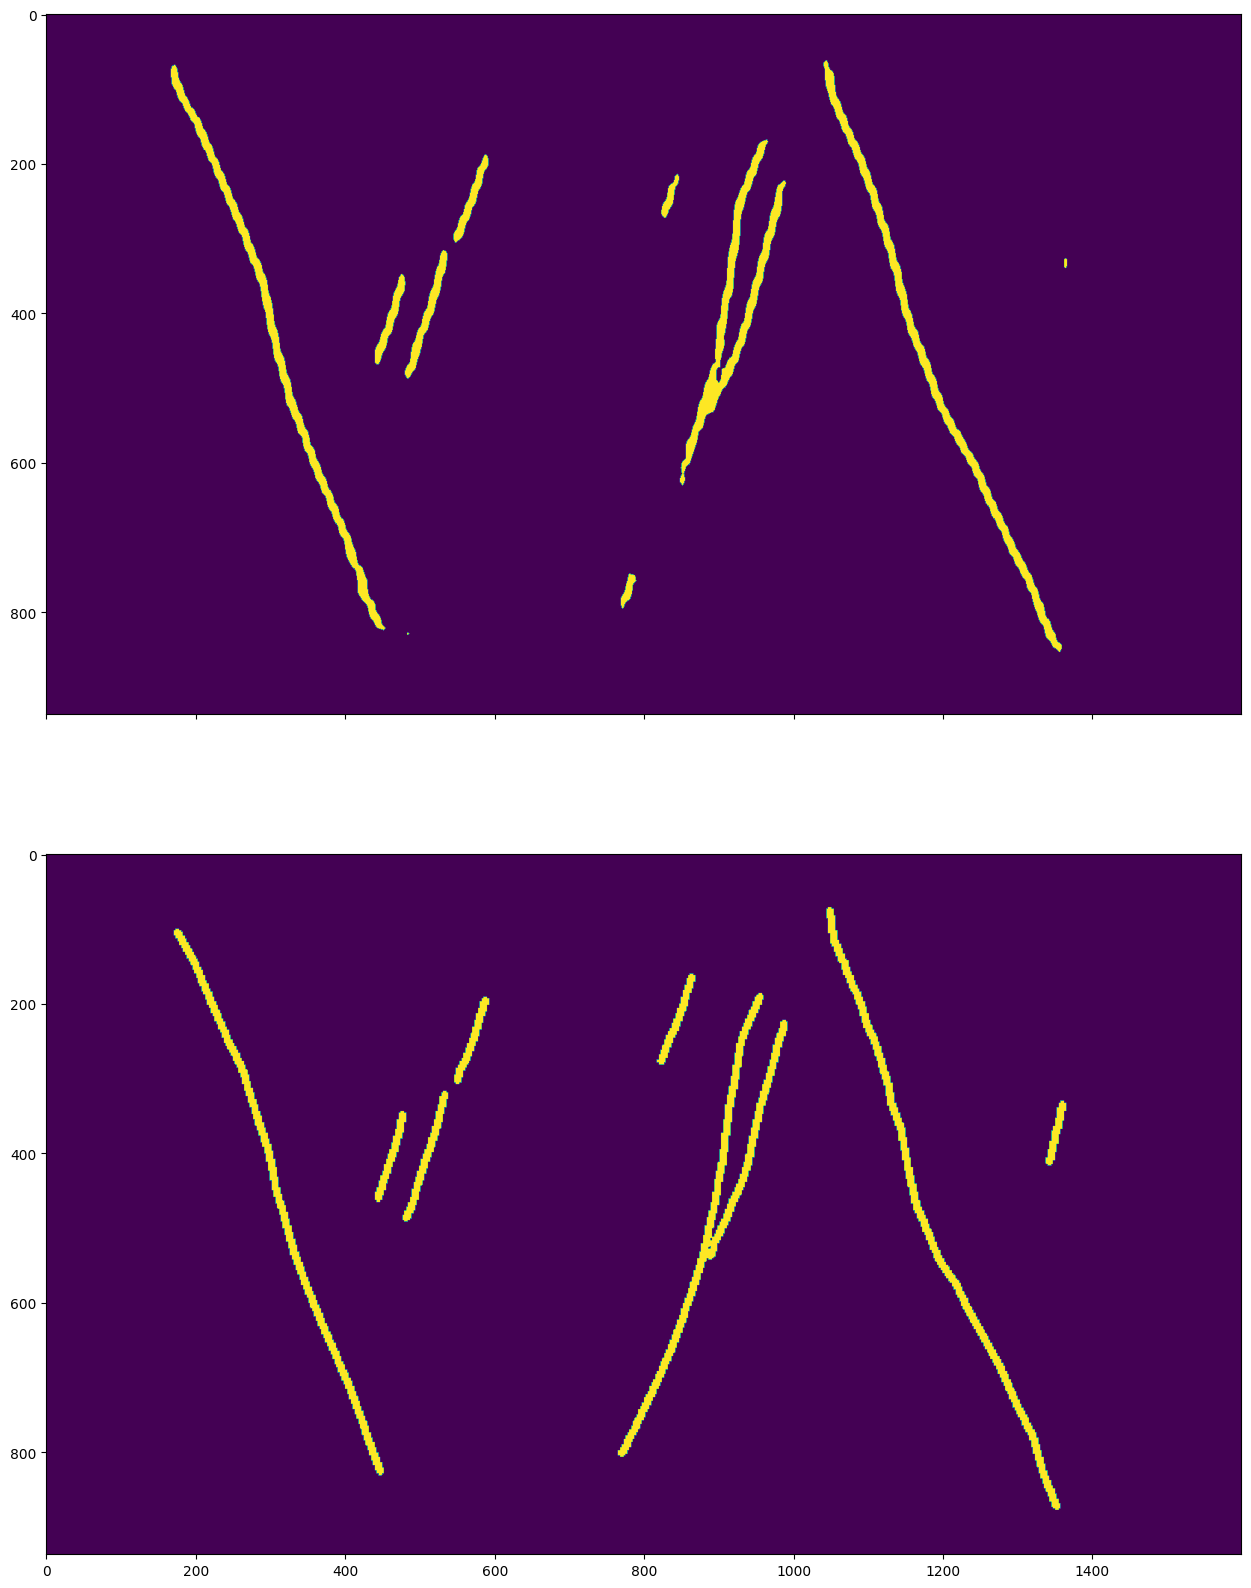

In [12]:
THRESHOLD = 0.5
weights_path = 'data/weights/Latest.pth.gz'

# подгрузка модели нейросети
network = torchvision.models.segmentation.deeplabv3_resnet50(num_classes=1, aux_loss=True)
network.backbone.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
network.load_state_dict(torch.load(weights_path, map_location=device))
# network = network.to(device)
network.eval()

# model = Unet()
# model.load_state_dict(torch.load(weights_path, map_location=device))
# model.eval()

start_time = time.time()
img_window = ImageOps.grayscale(Image.fromarray(data))
window = transforms.ToTensor()(img_window)
window = window[None, :]
window.to(device)

output = network(window)['out']
output = output.squeeze().data.cpu().numpy()

output[output >= THRESHOLD] = 1
output[output < THRESHOLD] = 0

end_time = time.time()
print(end_time - start_time)


print(np.shape(output))
print(np.shape(labels))
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 20))
ax[0].imshow(output)
ax[1].imshow(labels);

## Предсказание множества горизонтов

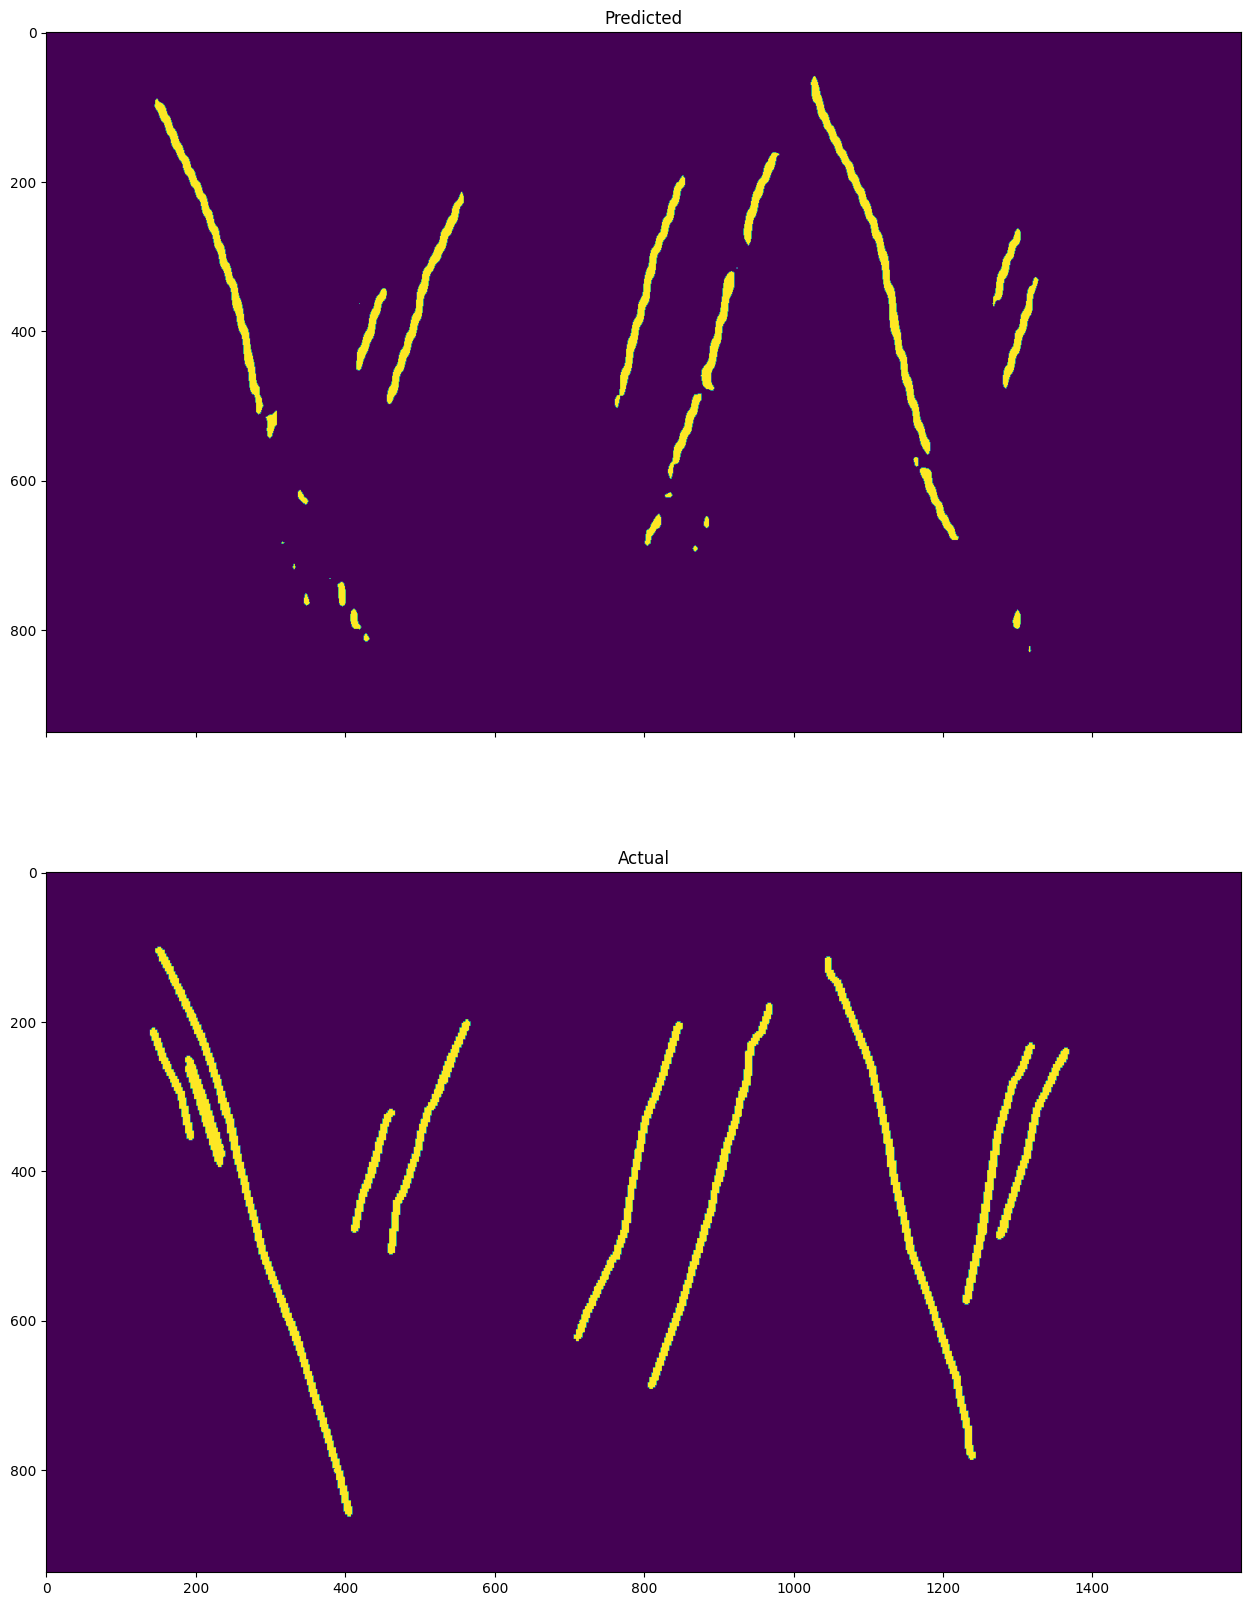

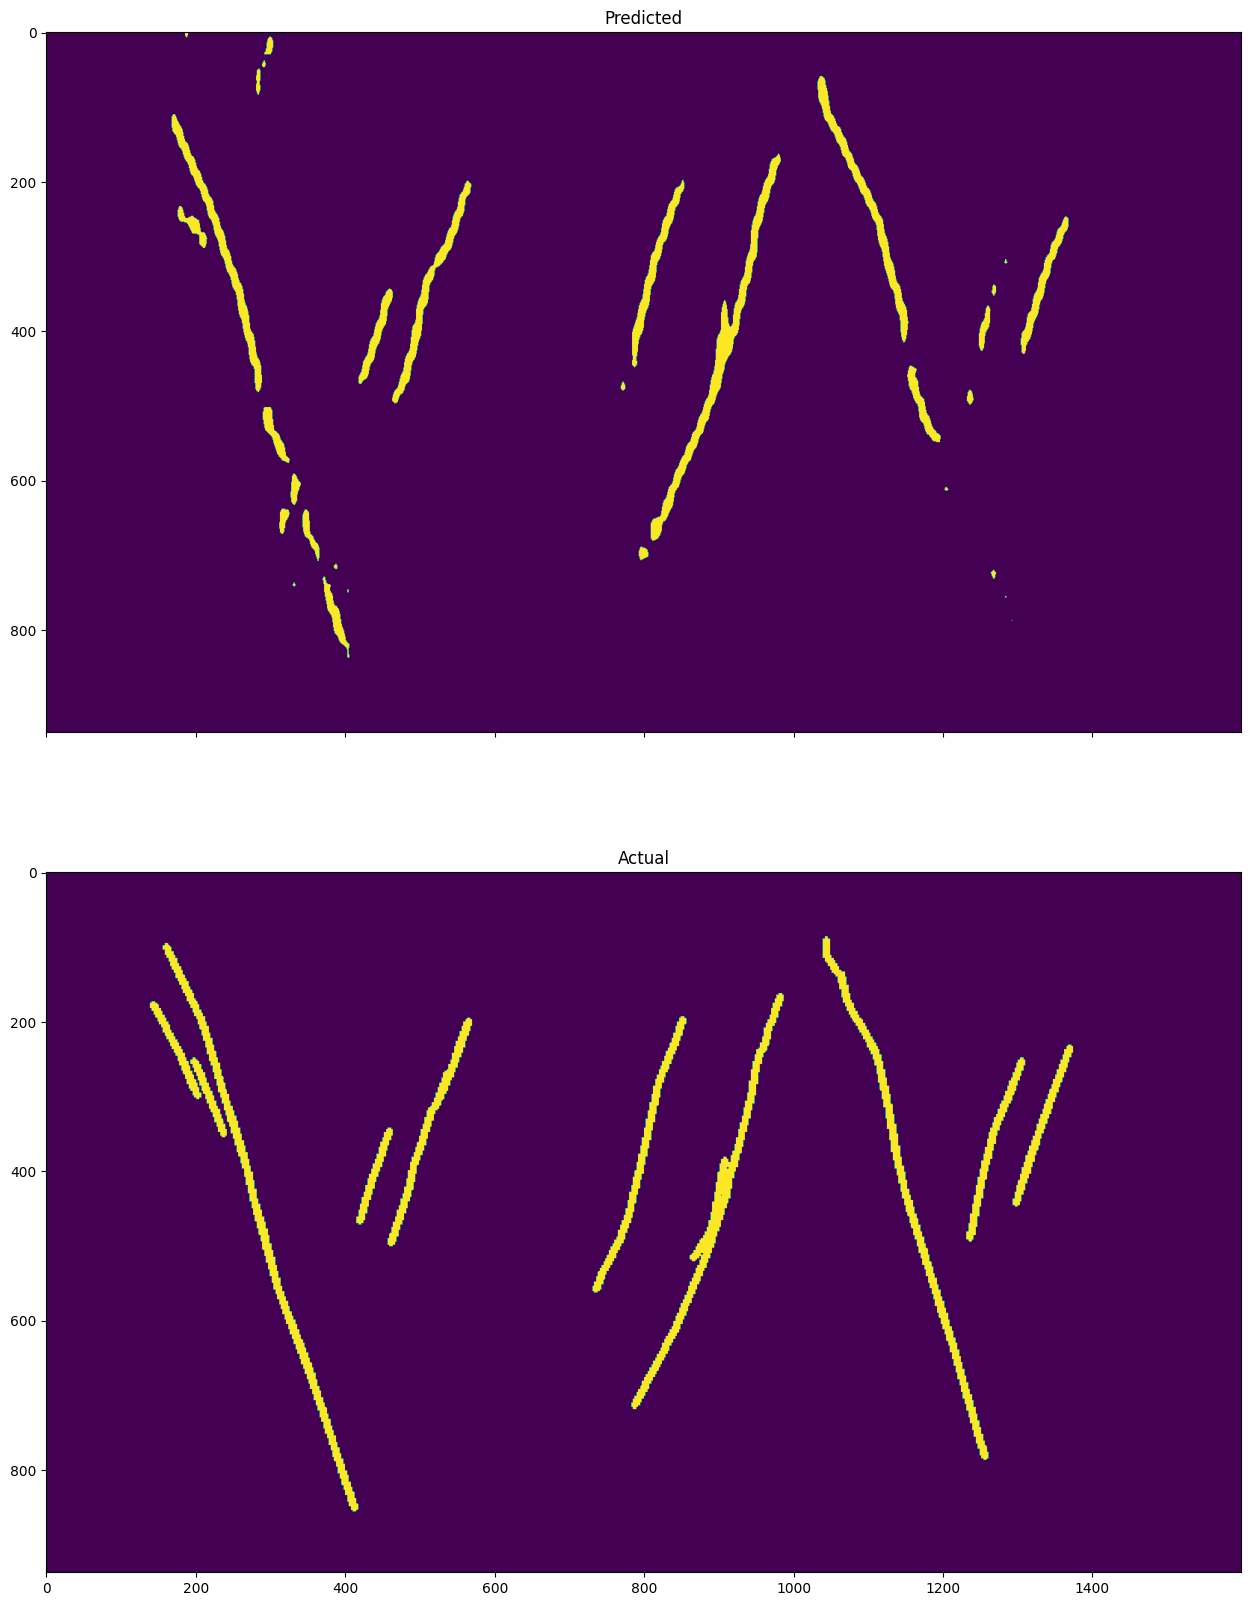

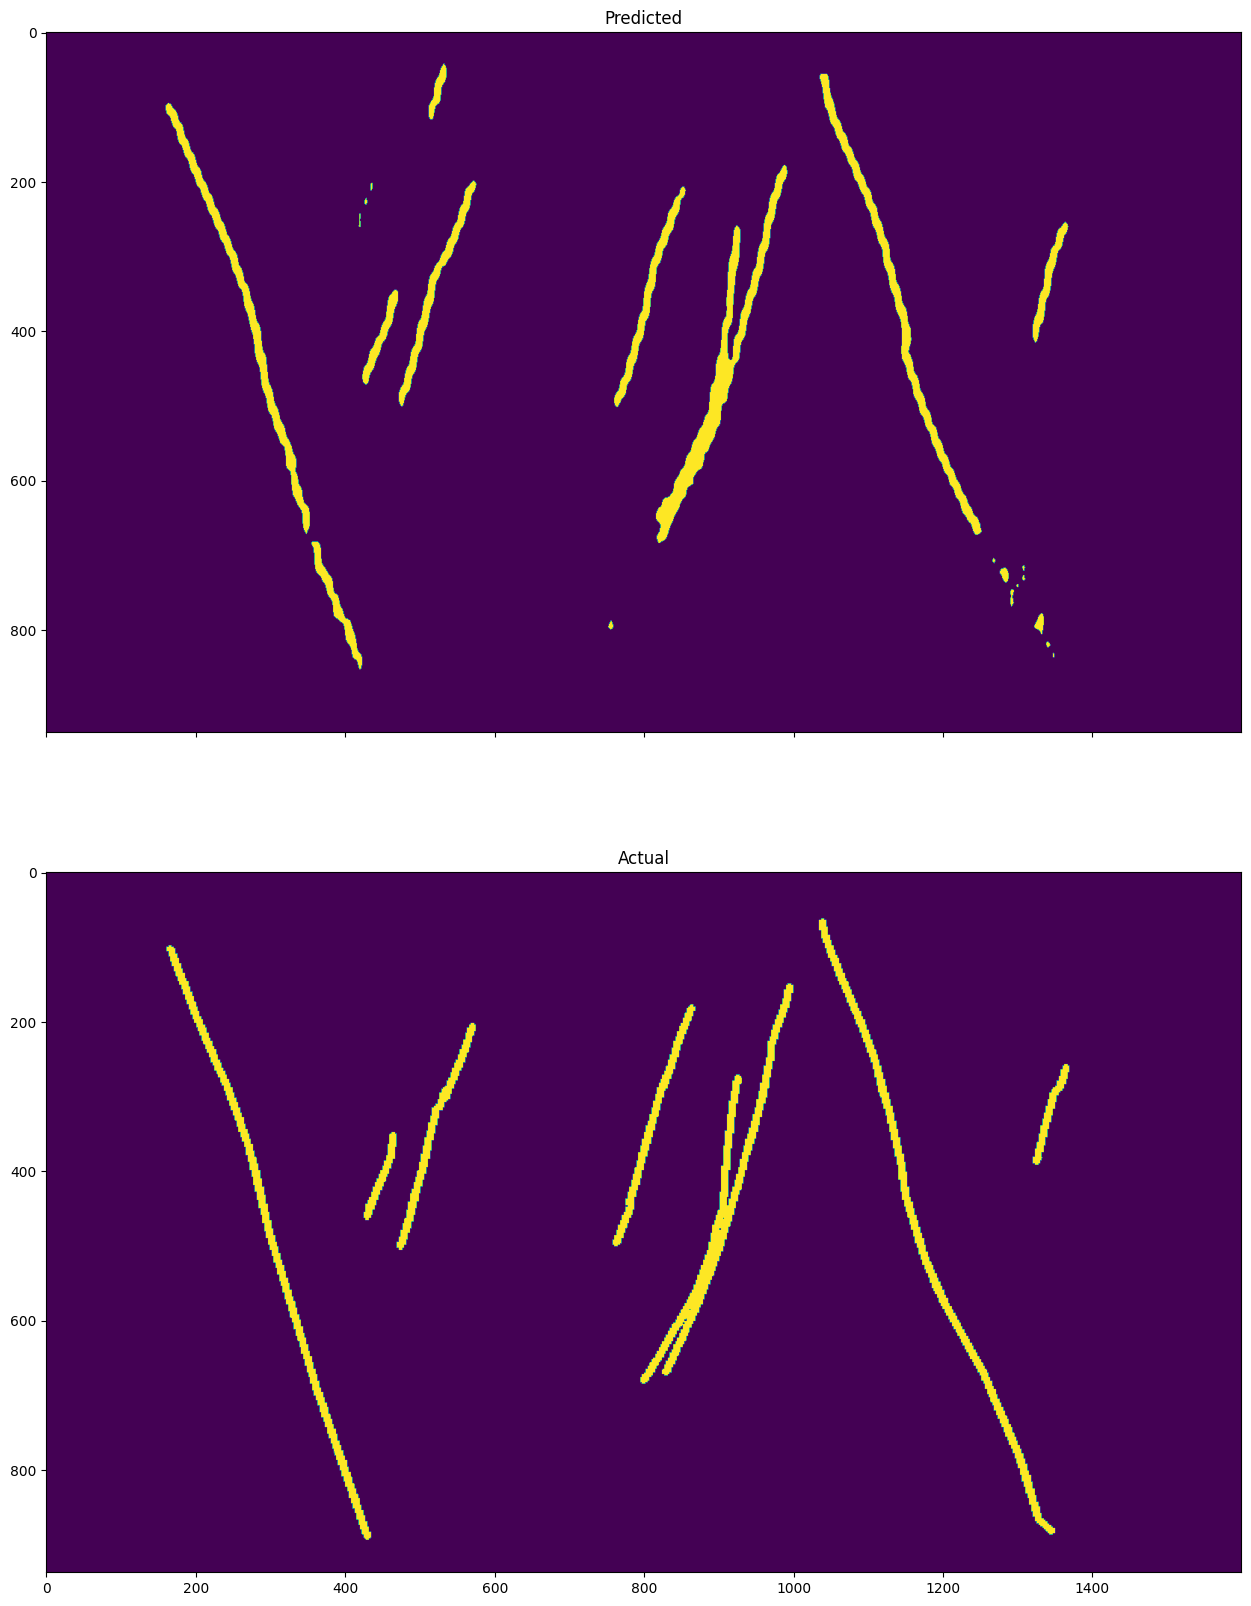

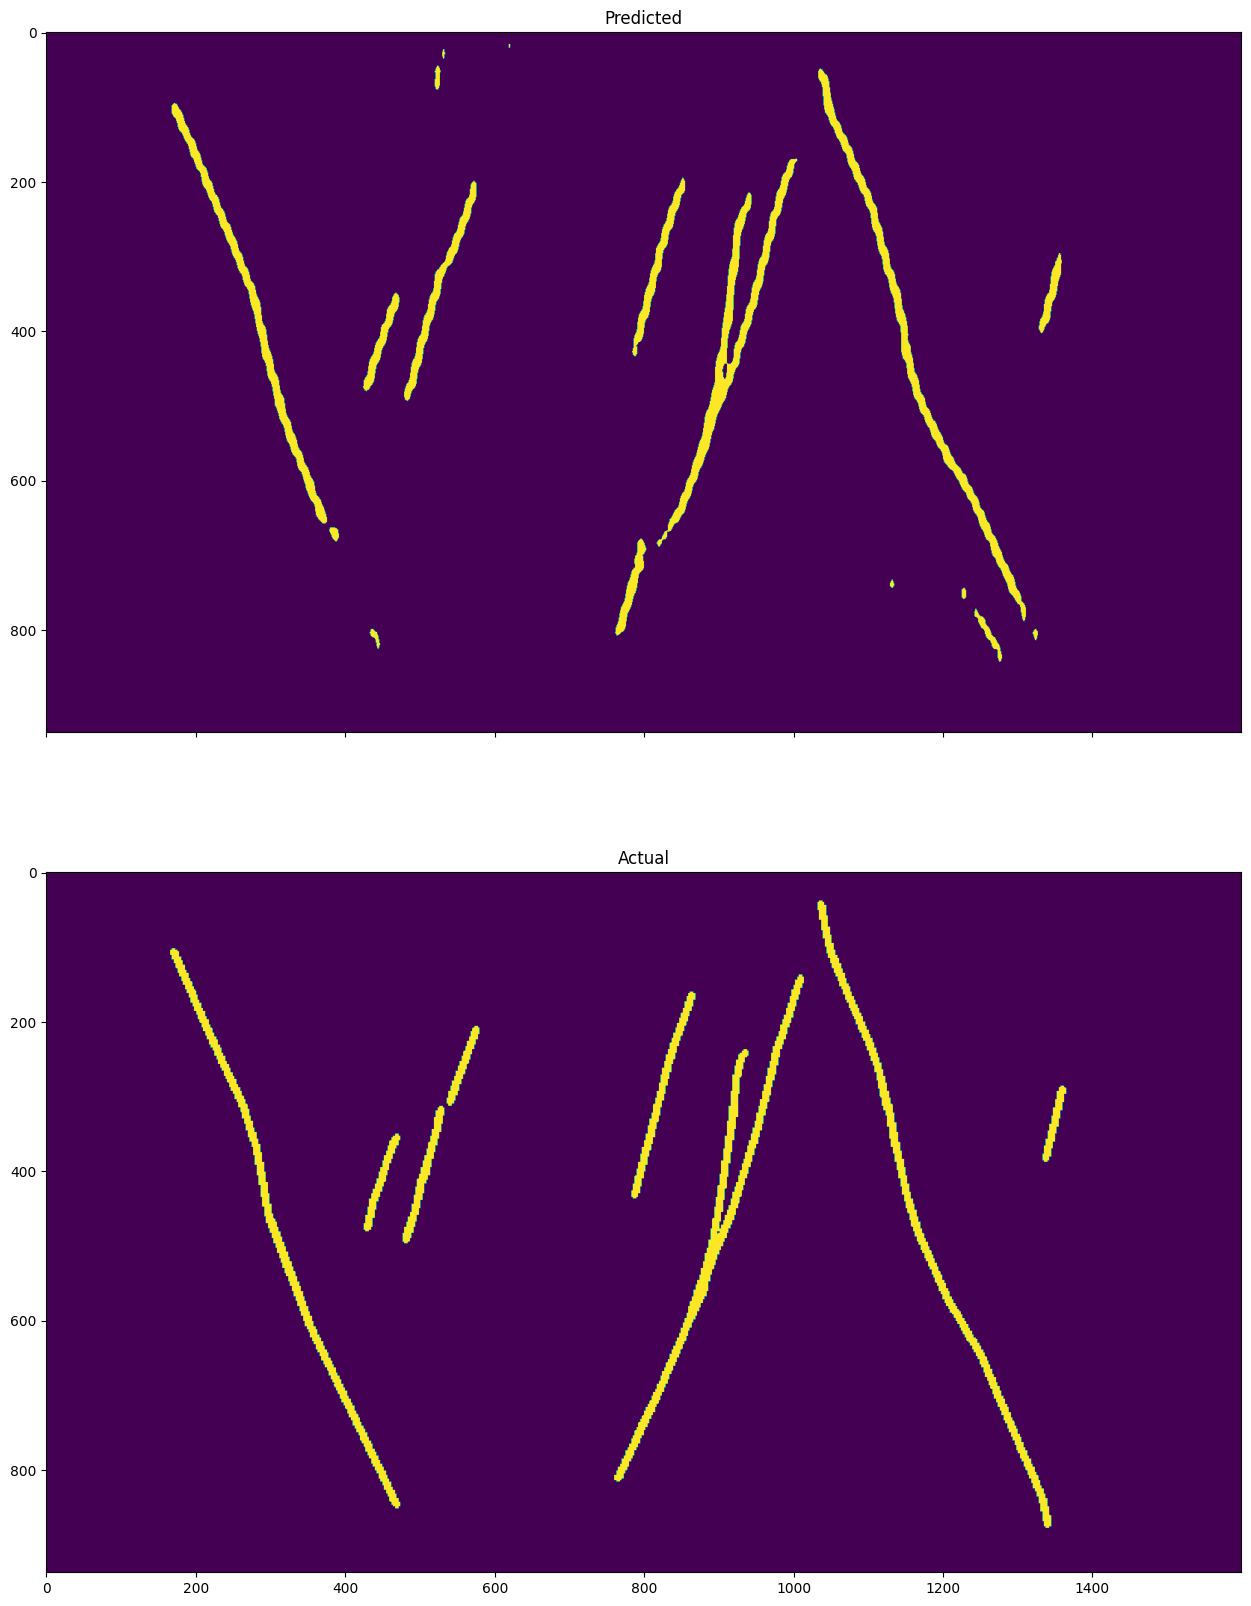

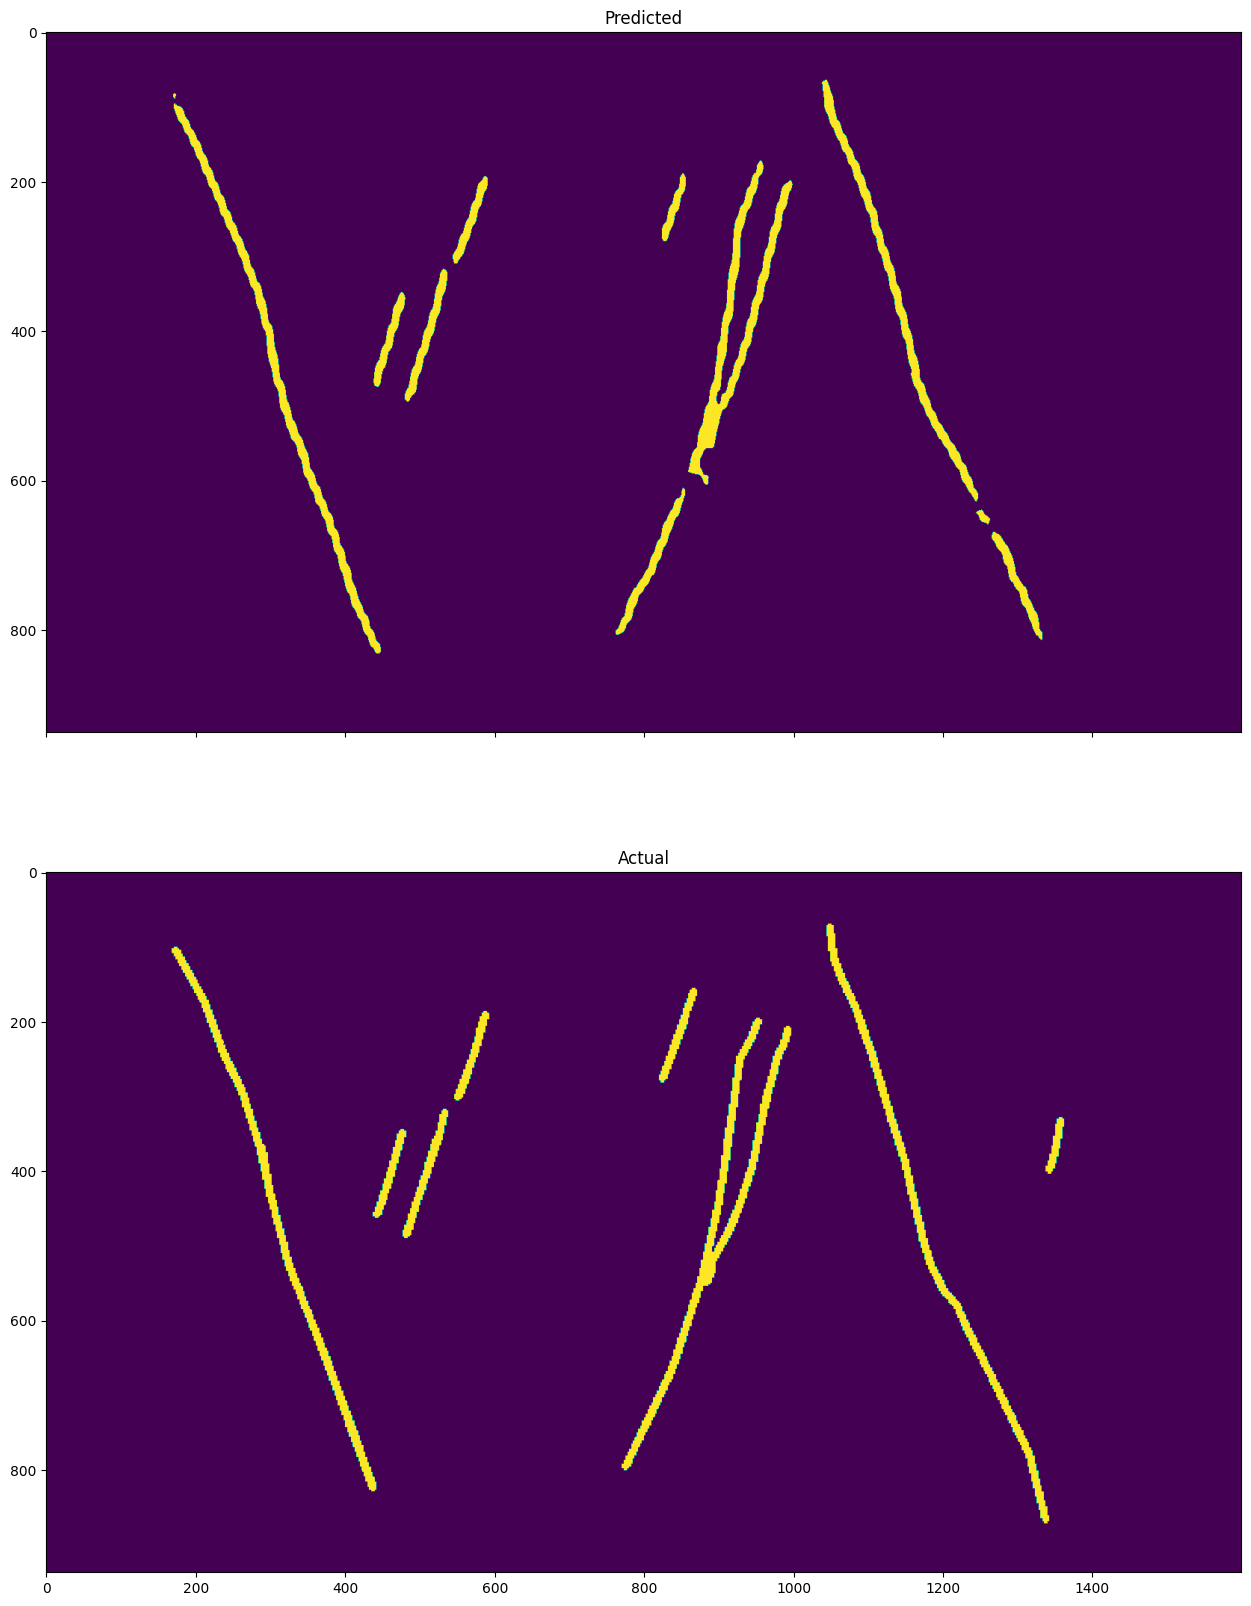

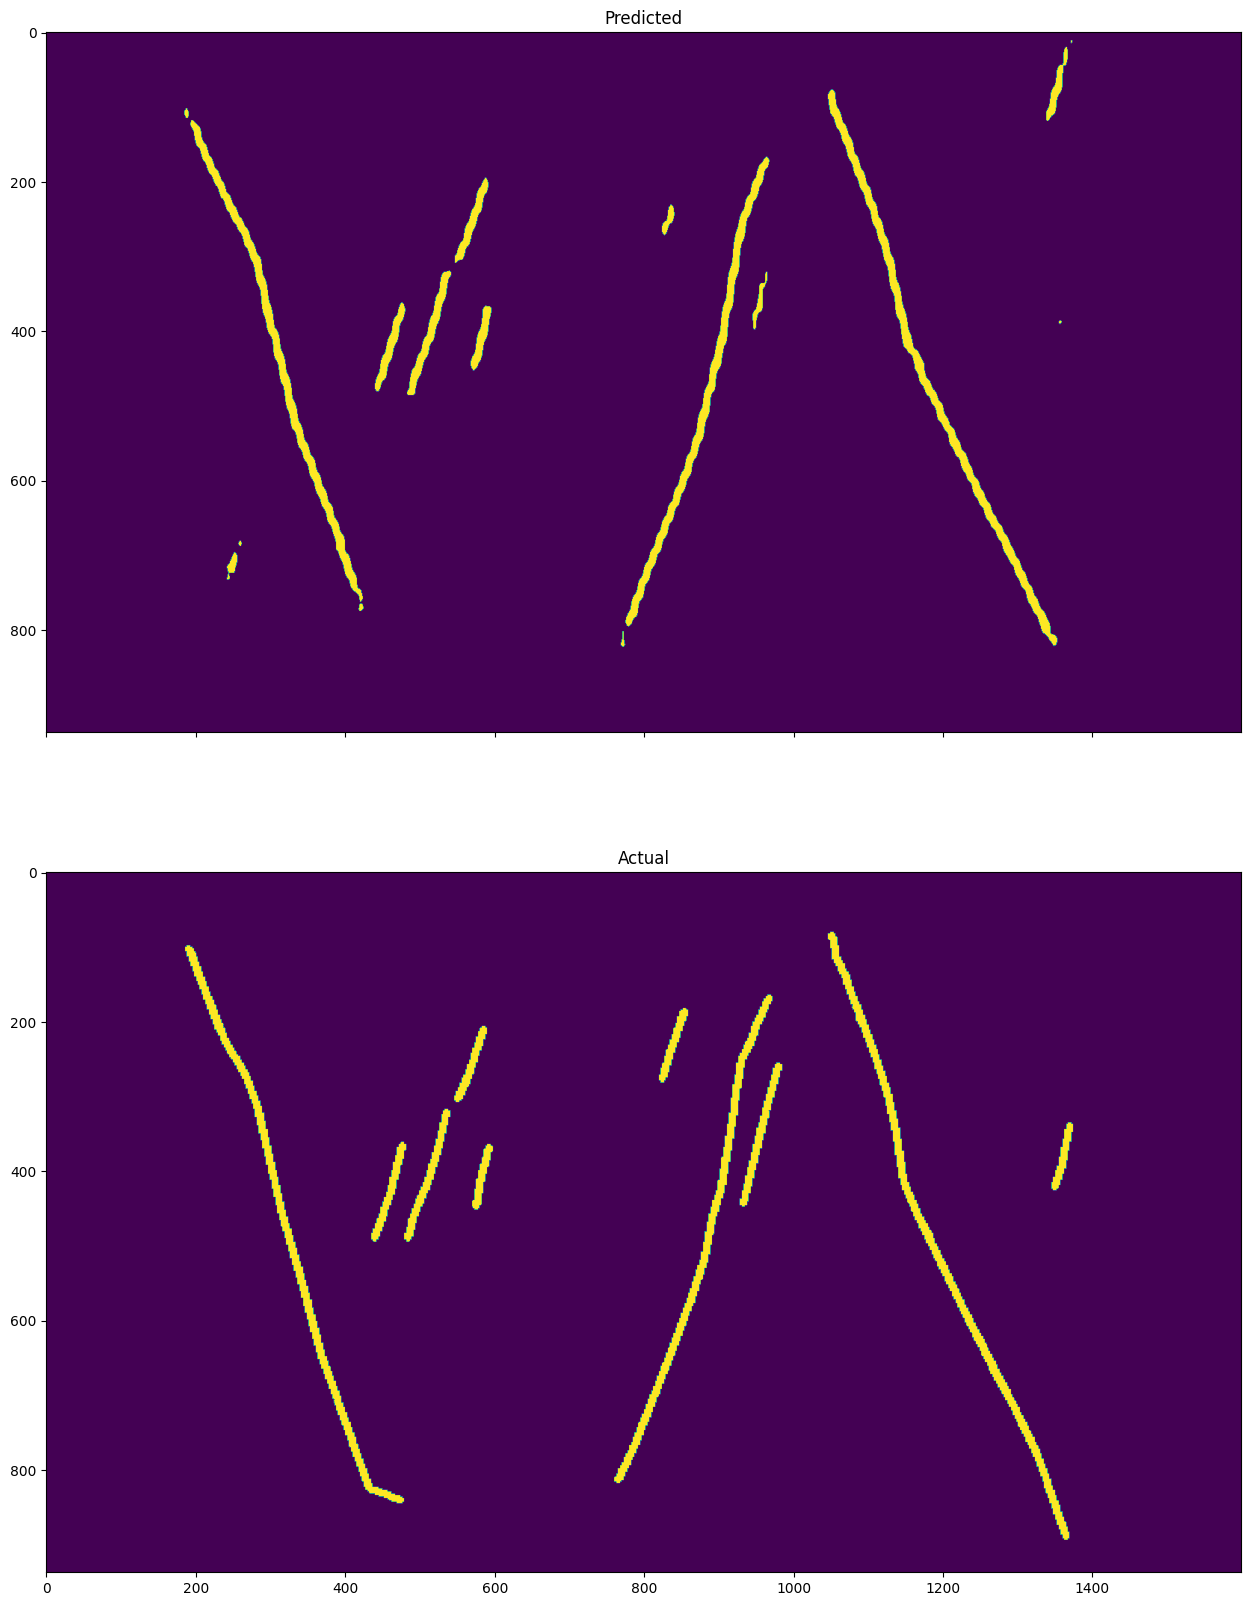

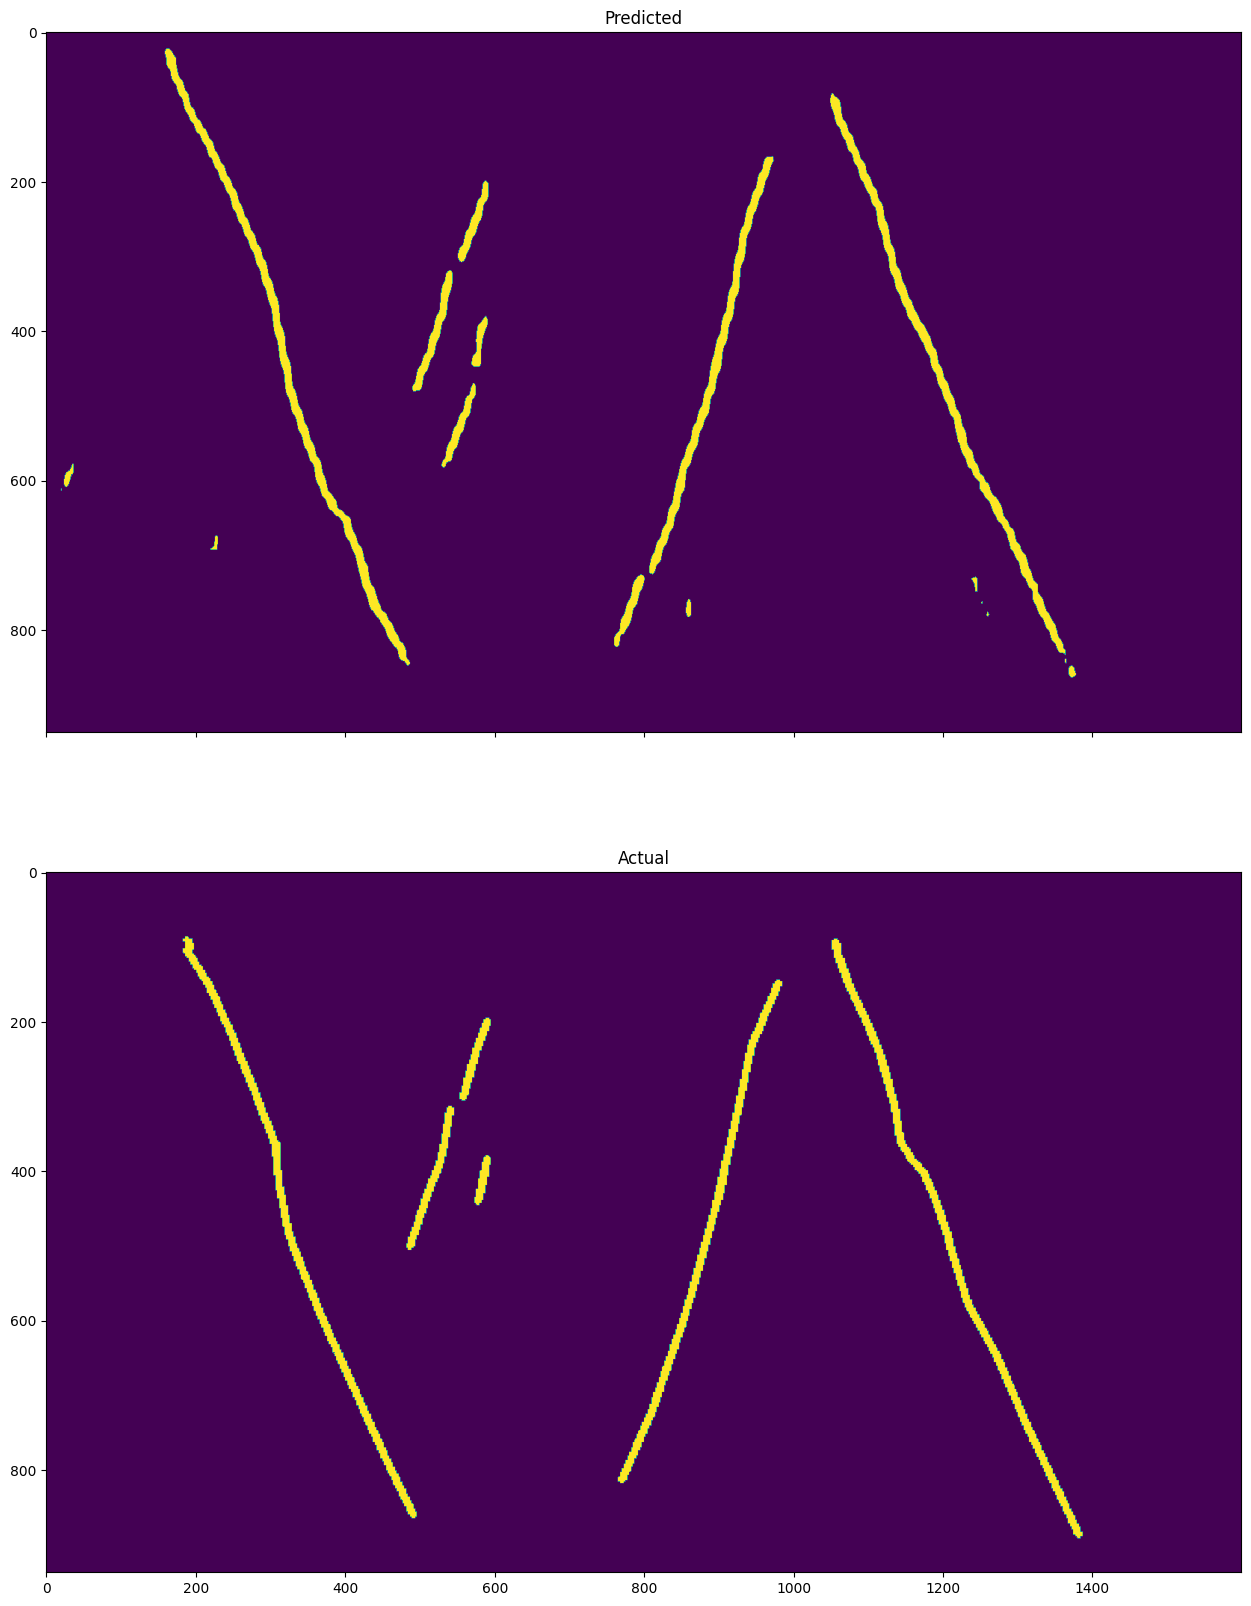

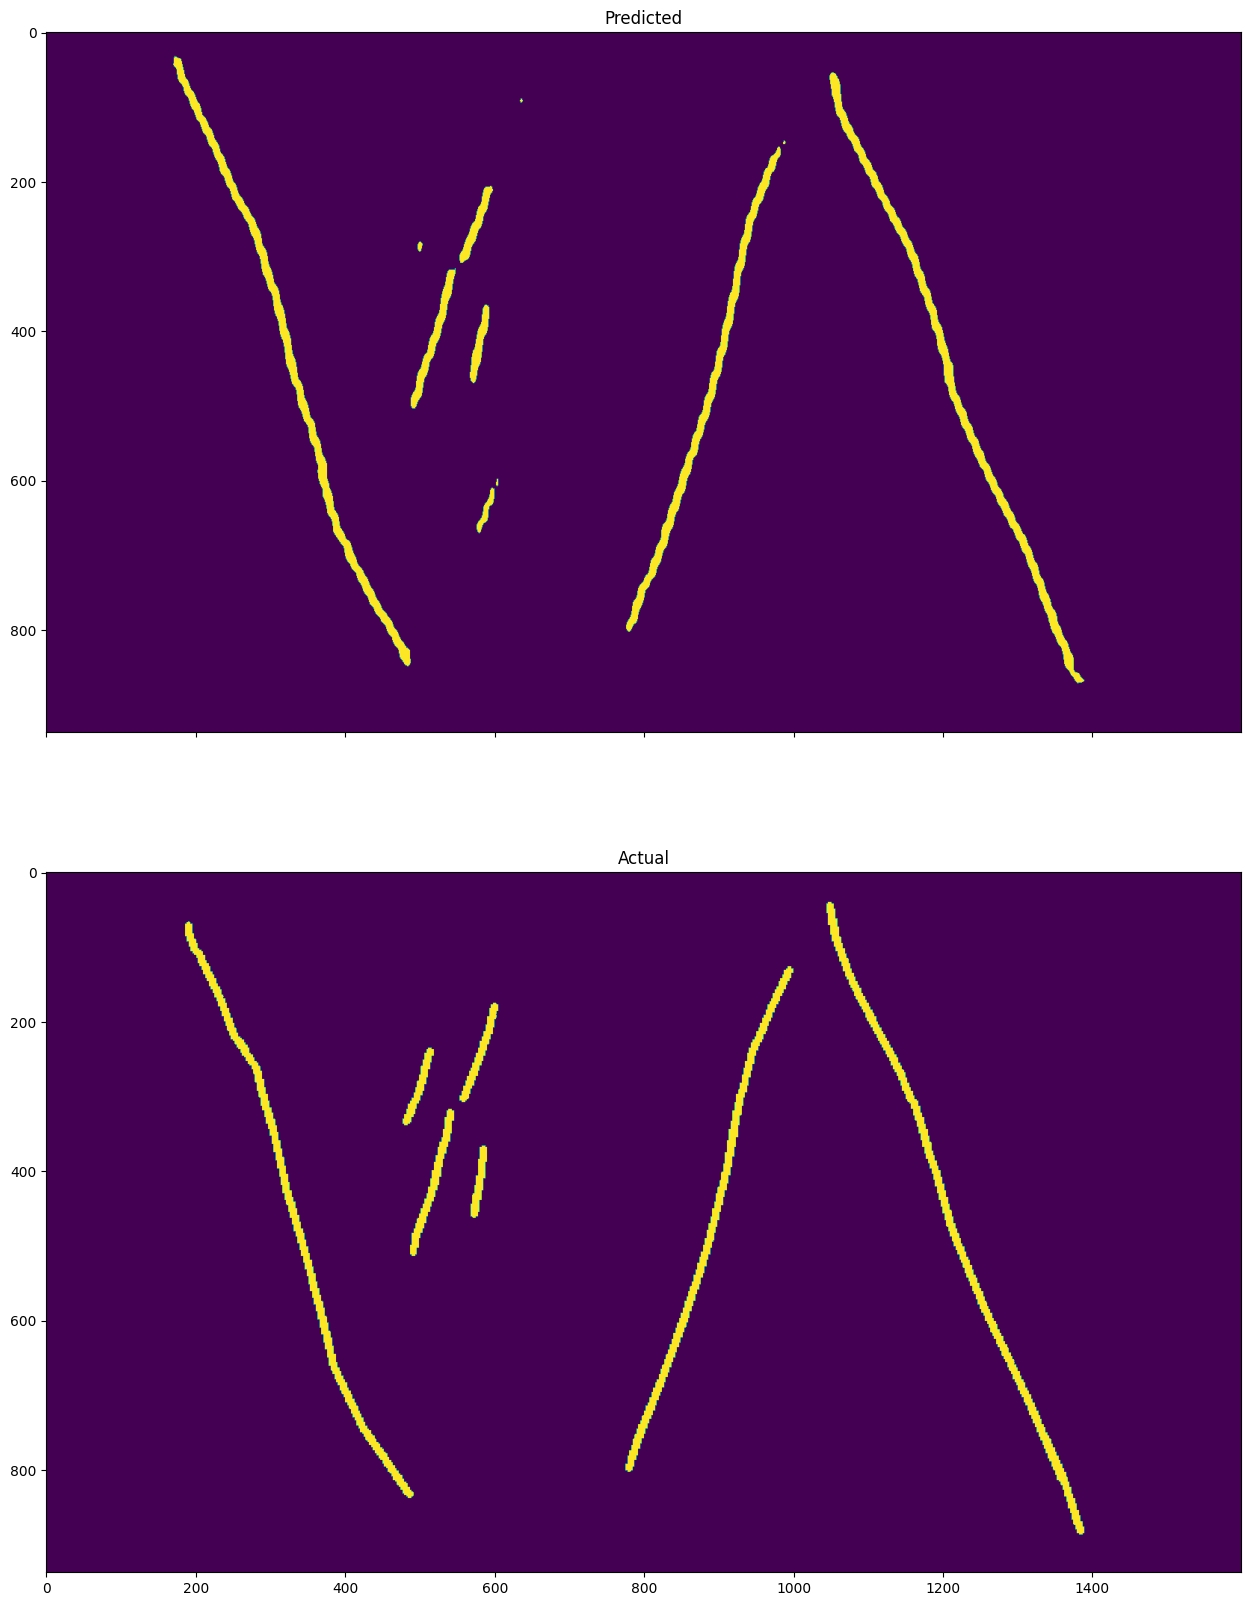

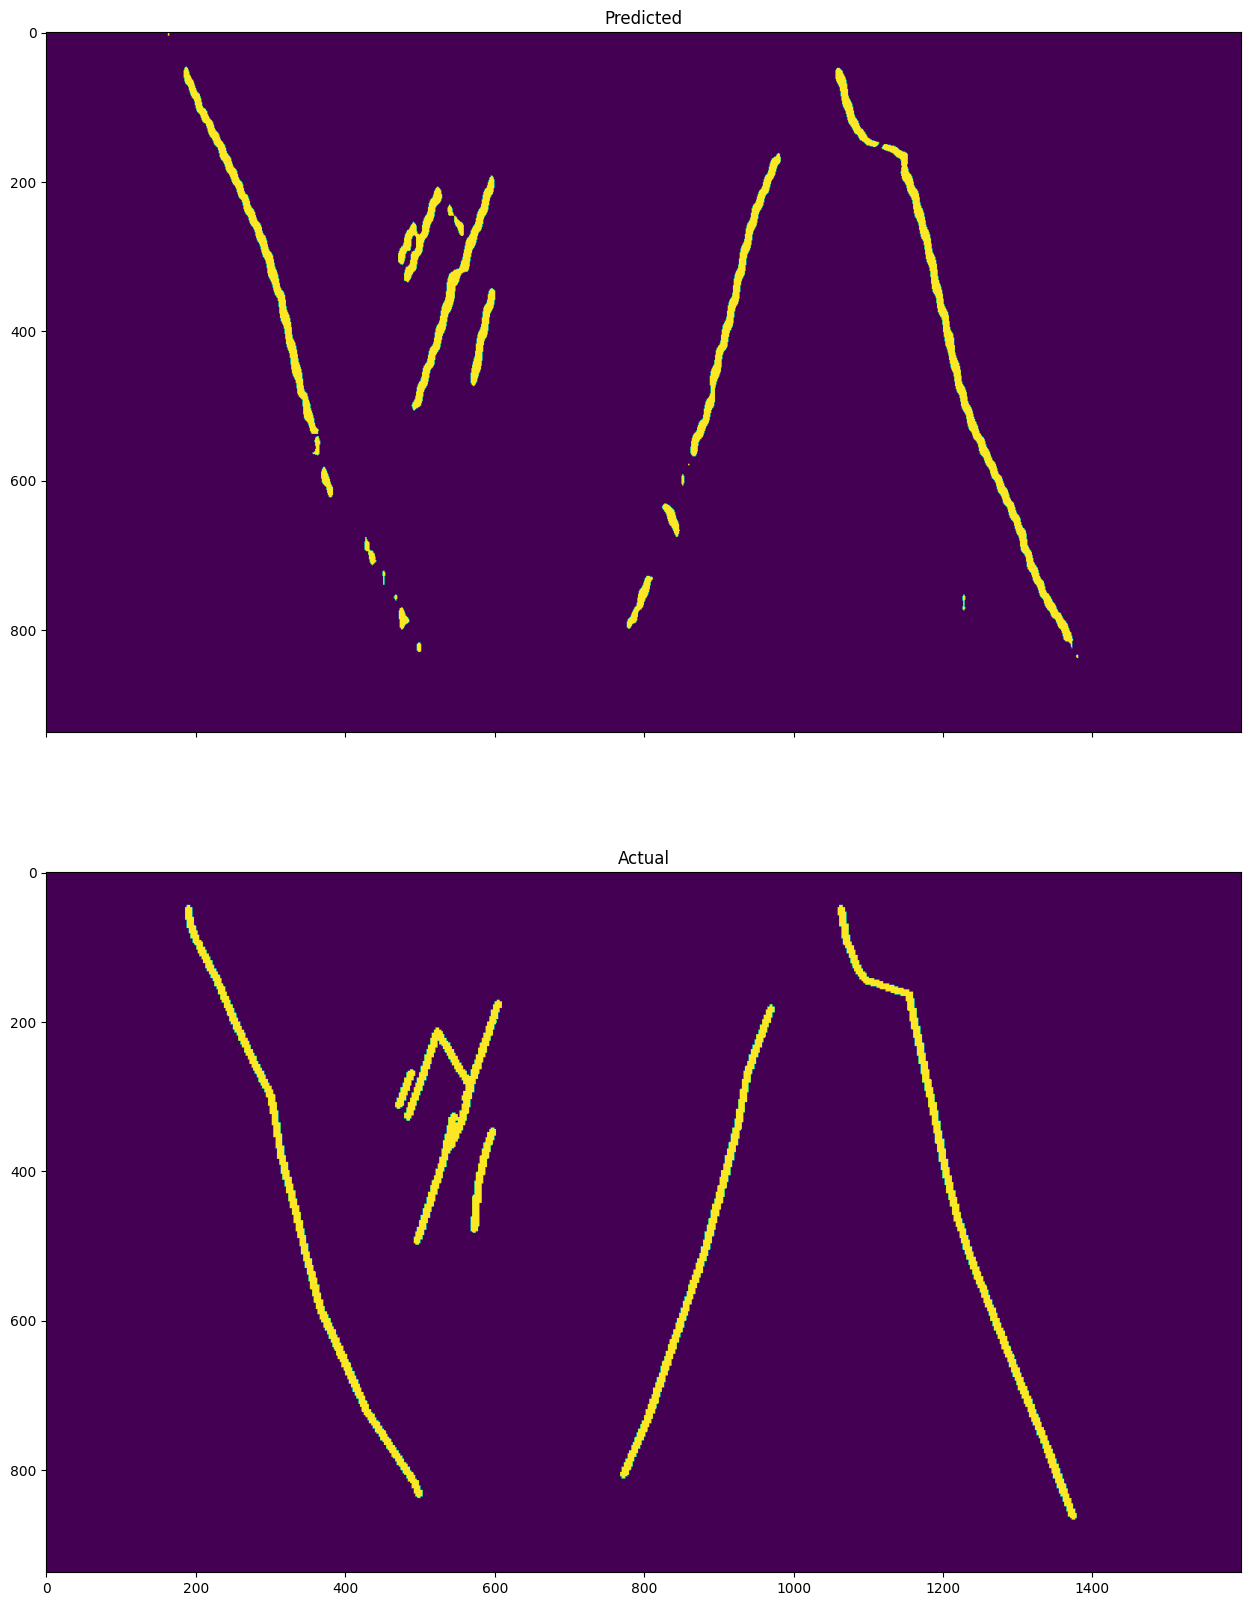

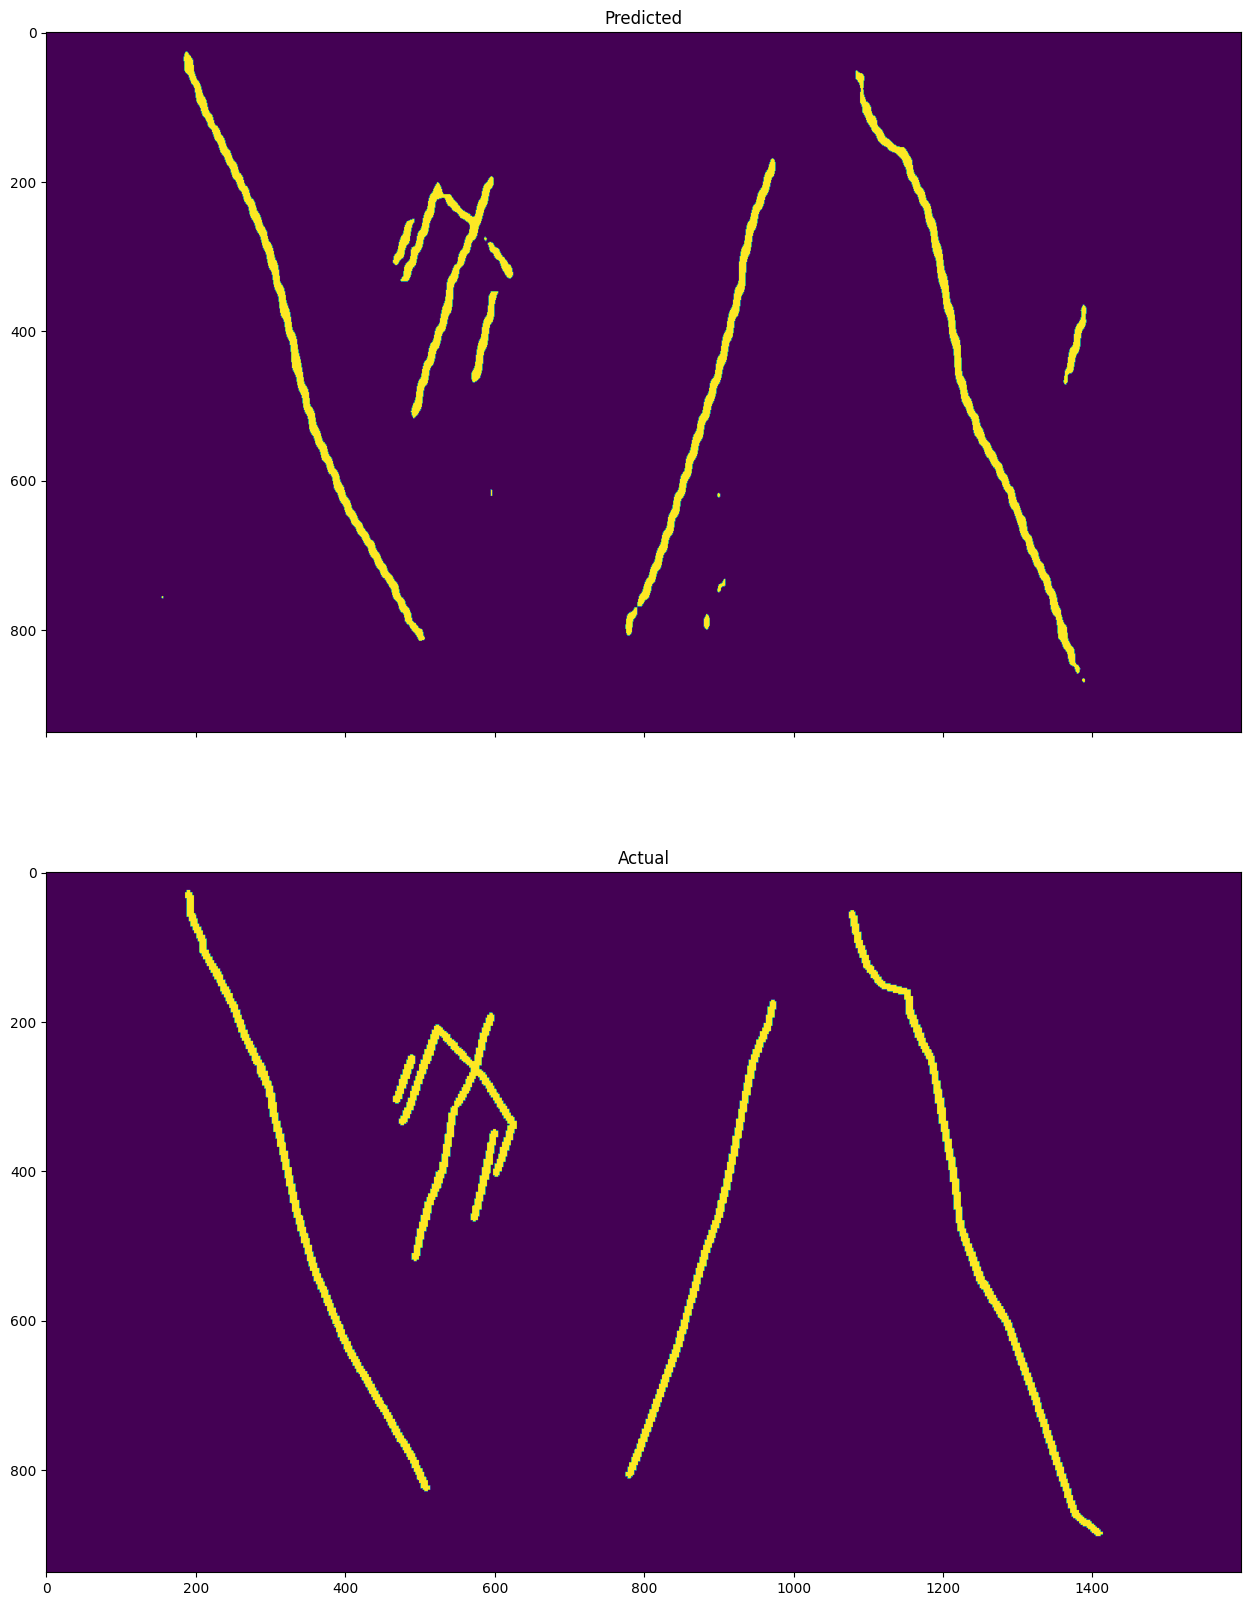

In [2]:
def pad_data(data, divisor=16):
    shape_y, shape_x = data.shape
    padding = [None, None]
    if shape_x % divisor != 0:
        for i in range(divisor):
            if data.shape[1] % divisor == 0:
                break
            data = np.c_[data,np.zeros(data.shape[0])]
        padding[0] = -i
    if shape_y % divisor != 0:
        for i in range(divisor):
            if data.shape[0] % divisor == 0:
                break
            data = np.r_[data,[np.zeros(data.shape[1])]]
        padding[1] = -i
    return data, padding


def predict_horizon(network, data_path: str, labels_path: str, horizon_nums, device, threshold: float, slicing: list, divisor: int):
    data = np.load(data_path)['arr_0'].T
    min_data_value = np.min(data)
    max_data_value = np.max(data)
    data = (data - min_data_value) / (max_data_value - min_data_value) * 255
    data = data[slicing[0]:slicing[1],slicing[2]:slicing[3]]

    labels = np.load(labels_path)['arr_0'].T
    labels = labels[slicing[0]:slicing[1],slicing[2]:slicing[3]]

    for horizon_num in horizon_nums:
        data_slice = data[:,:,horizon_num]
        labels_slice = labels[:,:,horizon_num]
        data_slice, data_padding = pad_data(data_slice, divisor)
        # fig, ax = plt.subplots()
        # ax.imshow(data_slice, cmap='gray_r')
        # fig, ax = plt.subplots()
        # ax.imshow(labels_slice, cmap='gray_r')

        img_horizon = ImageOps.grayscale(Image.fromarray(data_slice))
        horizon = transforms.ToTensor()(img_horizon)
        horizon = horizon[None, :]
        horizon.to(device)

        output = network(horizon)['out']
        output = output.squeeze().data.cpu().numpy()
        output = output[:data_padding[1],:data_padding[0]]

        output[output >= threshold] = 1
        output[output < threshold] = 0

        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 20))
        ax[0].set_title("Predicted")
        ax[0].imshow(output)
        ax[1].set_title("Actual")
        ax[1].imshow(labels_slice)


THRESHOLD = 0.5
weights_path = 'data/weights/Latest.pth.gz'

# подгрузка модели нейросети
network = torchvision.models.segmentation.deeplabv3_resnet50(num_classes=1, aux_loss=True)
network.backbone.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
network.load_state_dict(torch.load(weights_path, map_location=device))
# network = network.to(device)
network.eval()

predict_horizon(network, "seistrain4.npz", "faulttrain4.npz", range(0, 100, 10), device, THRESHOLD, slicing=[600, None, 400, 2000], divisor=16)

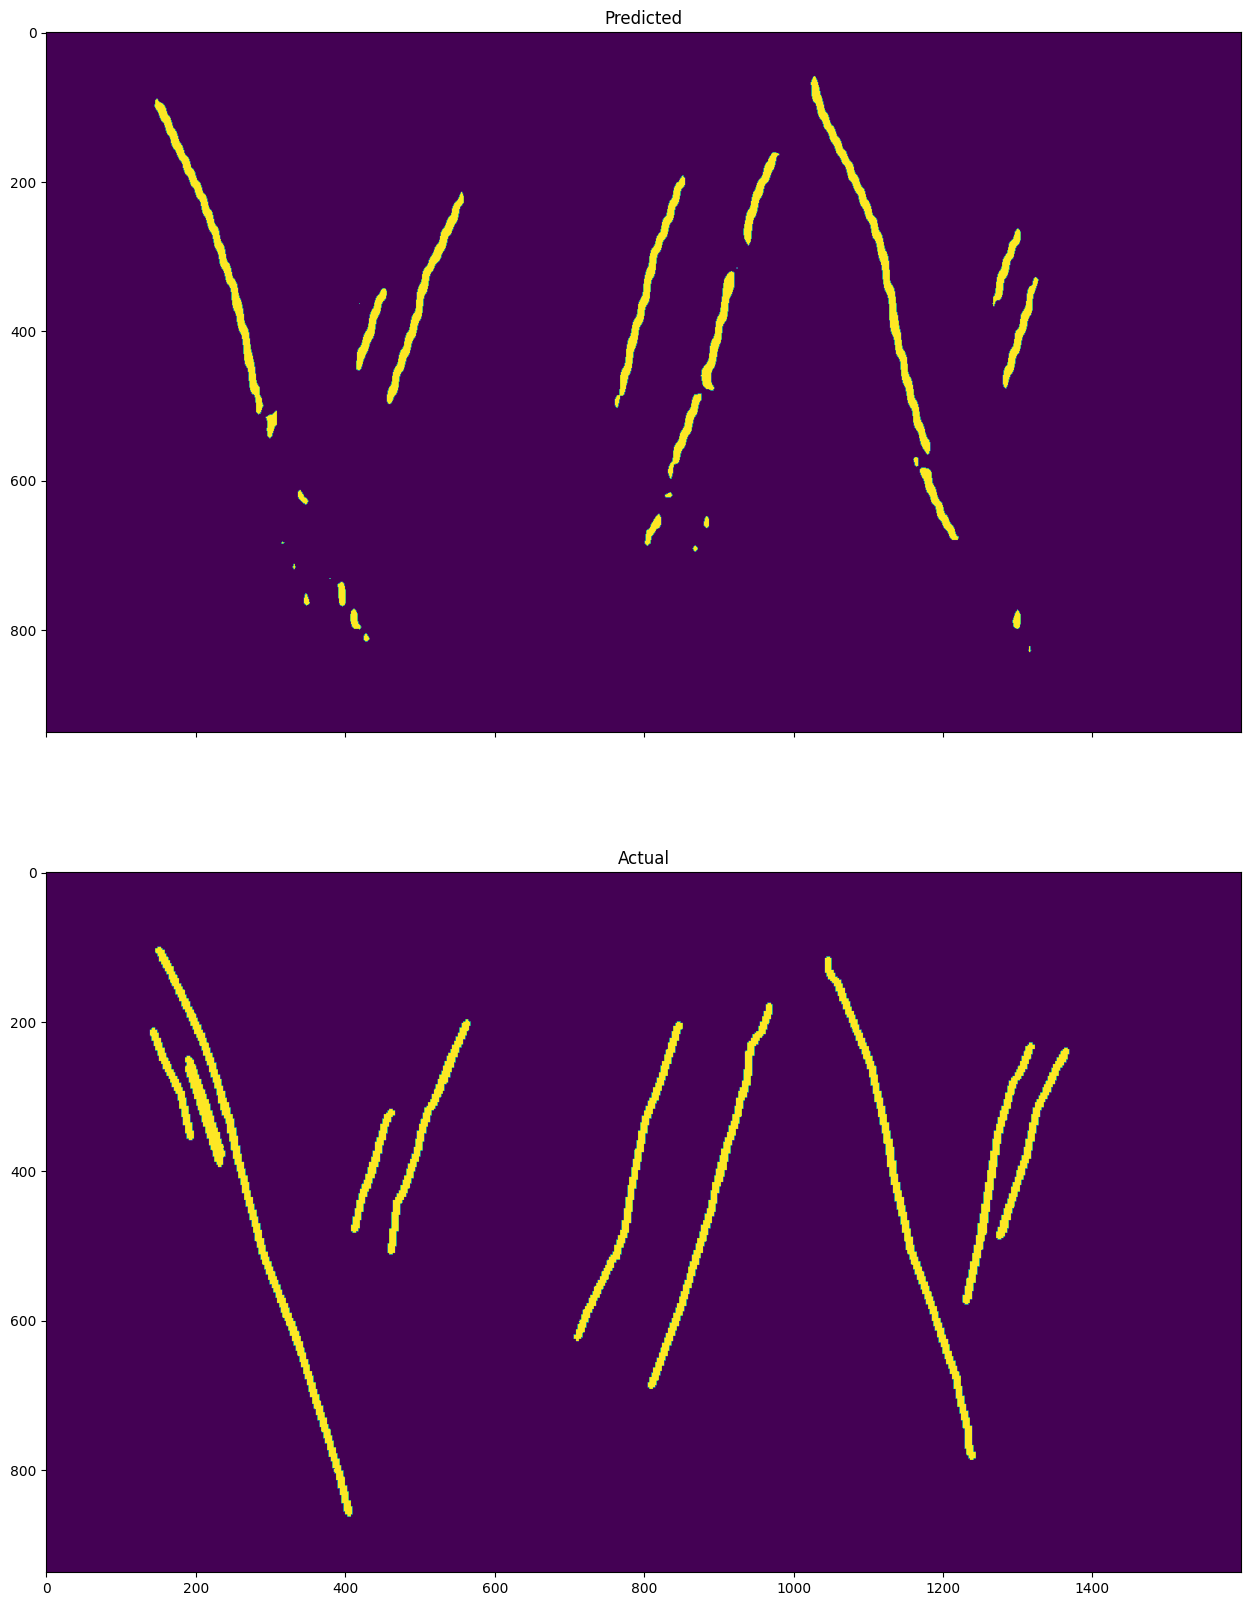

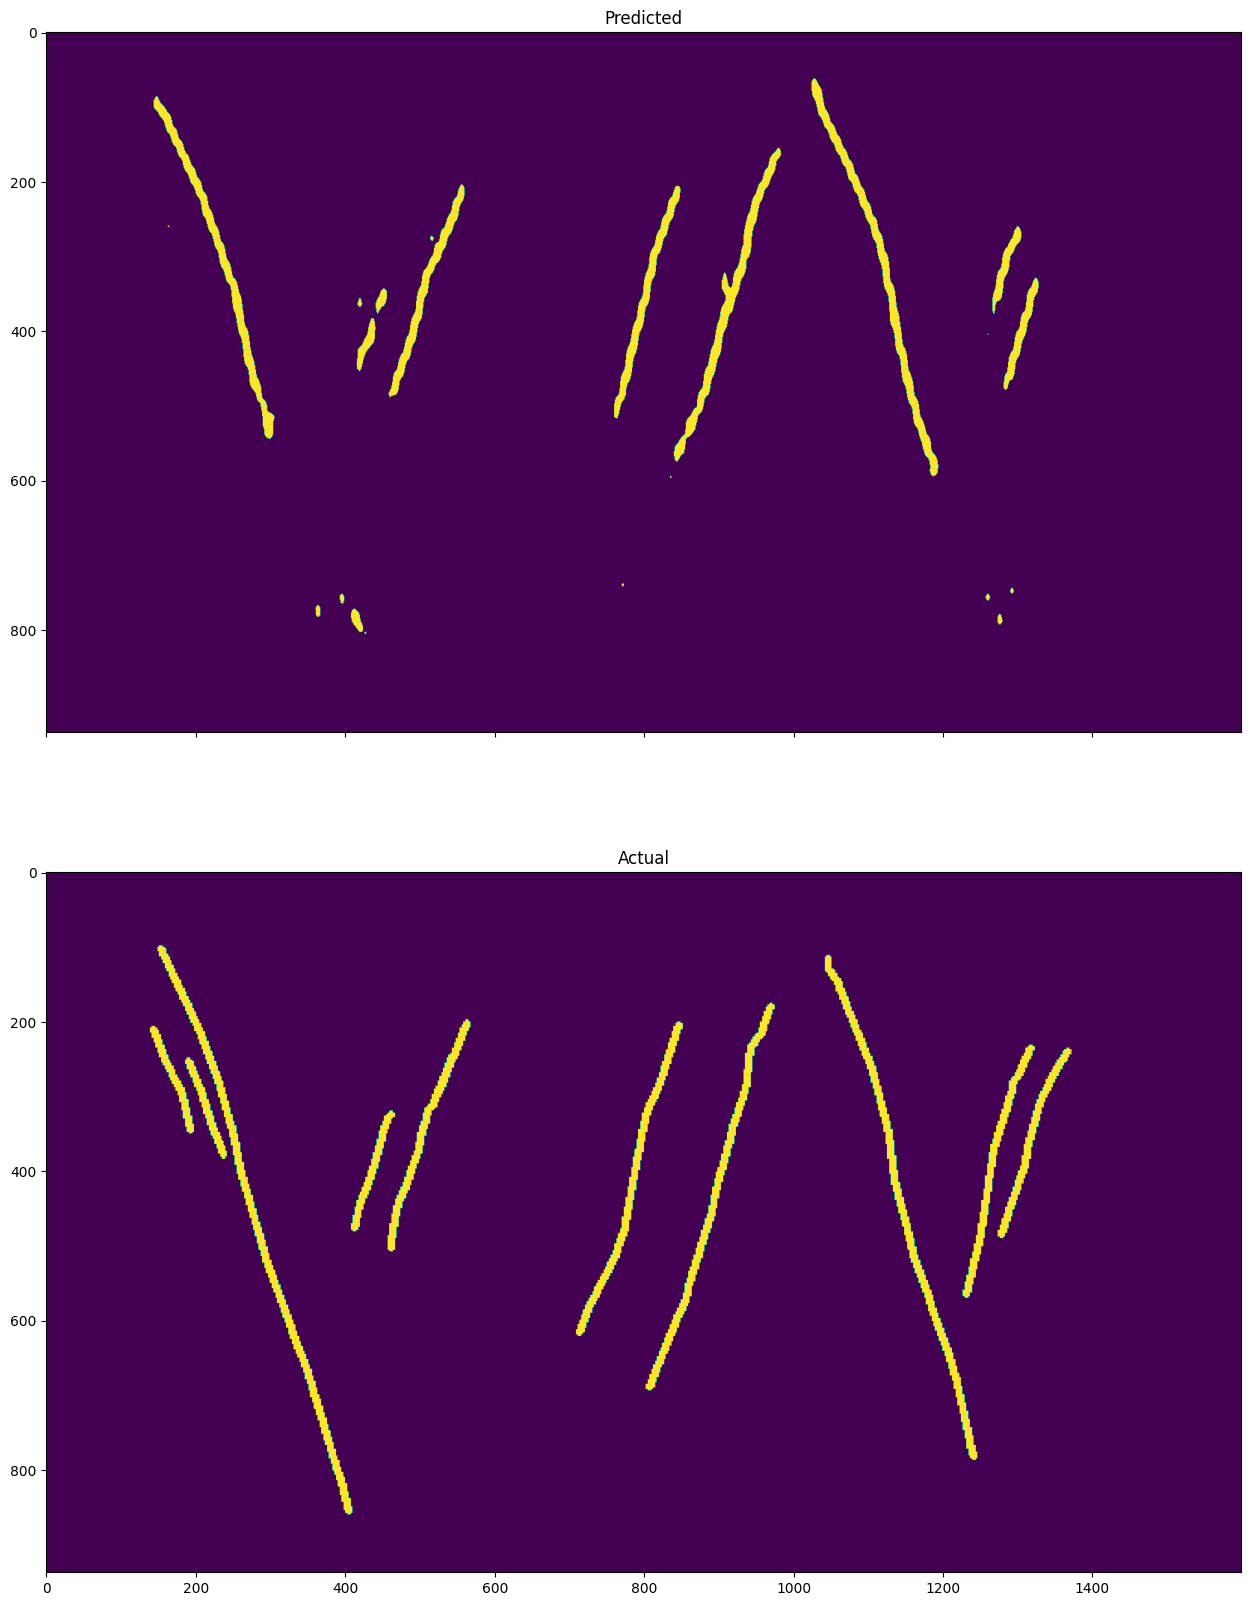

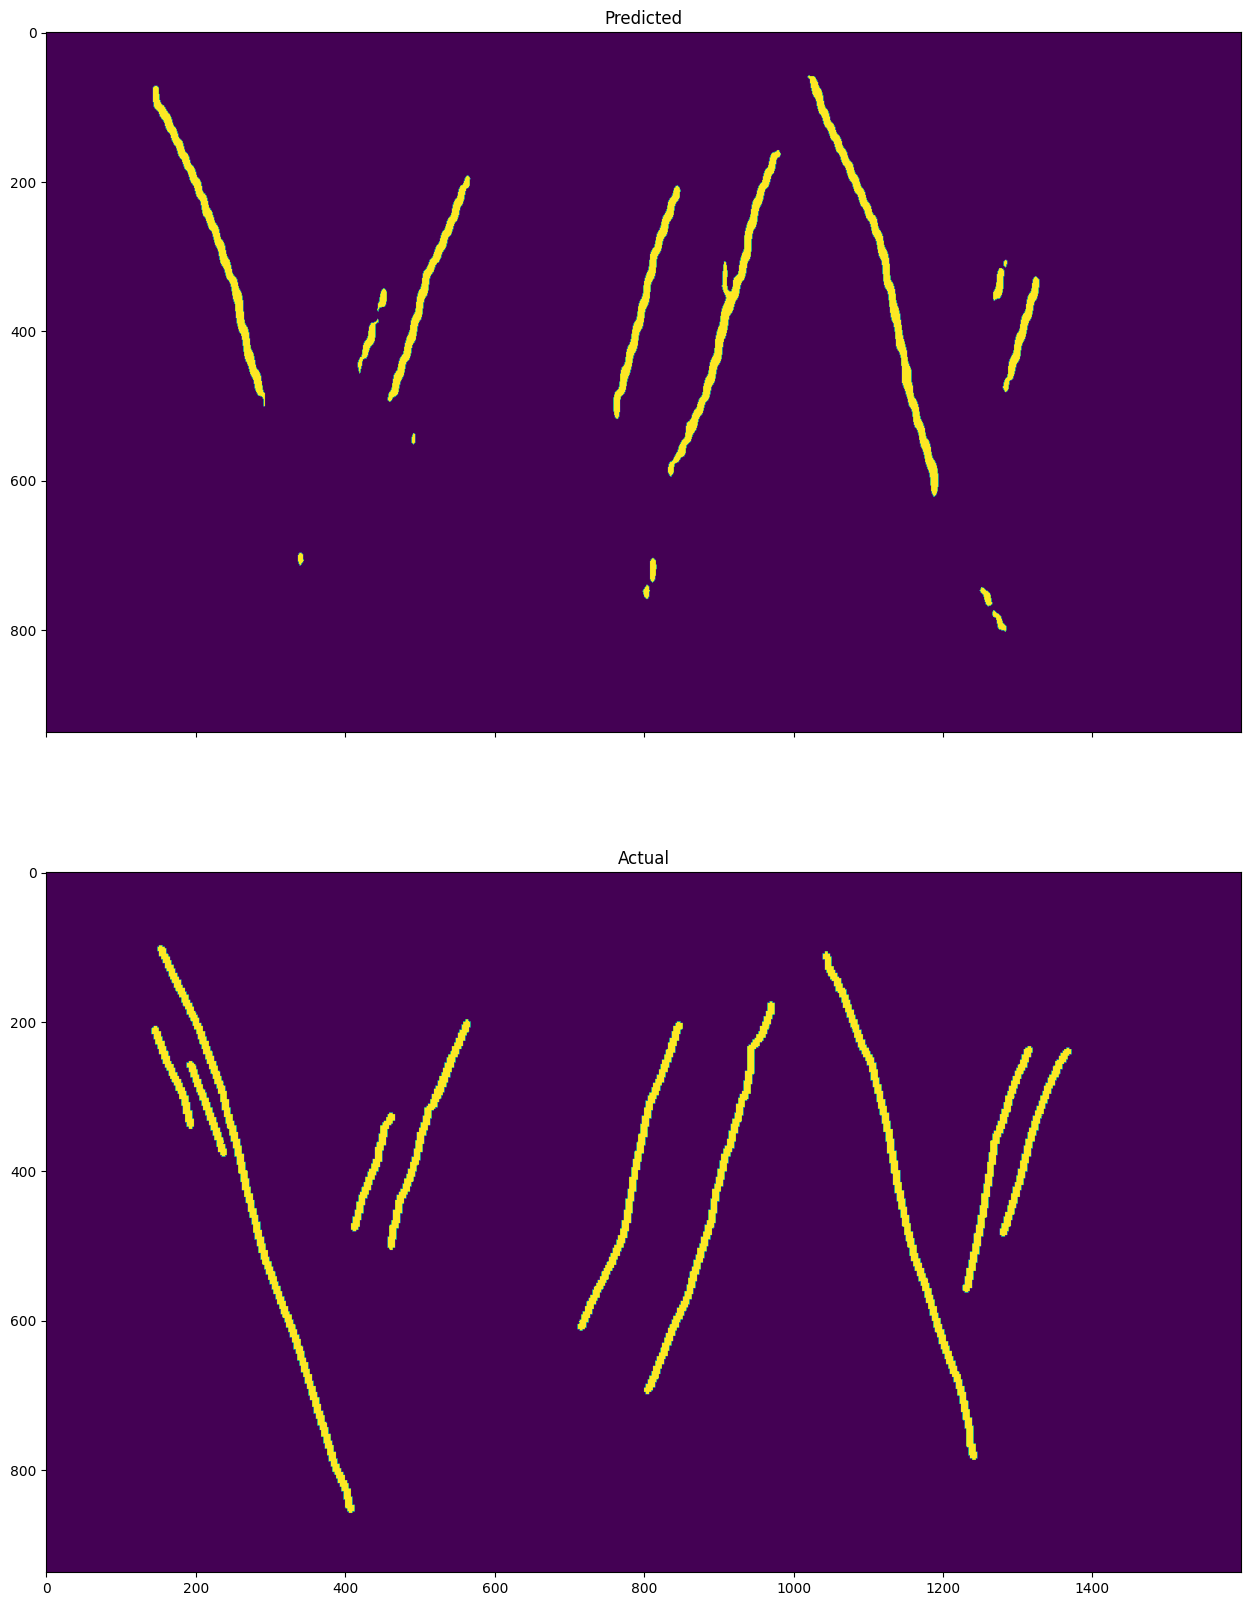

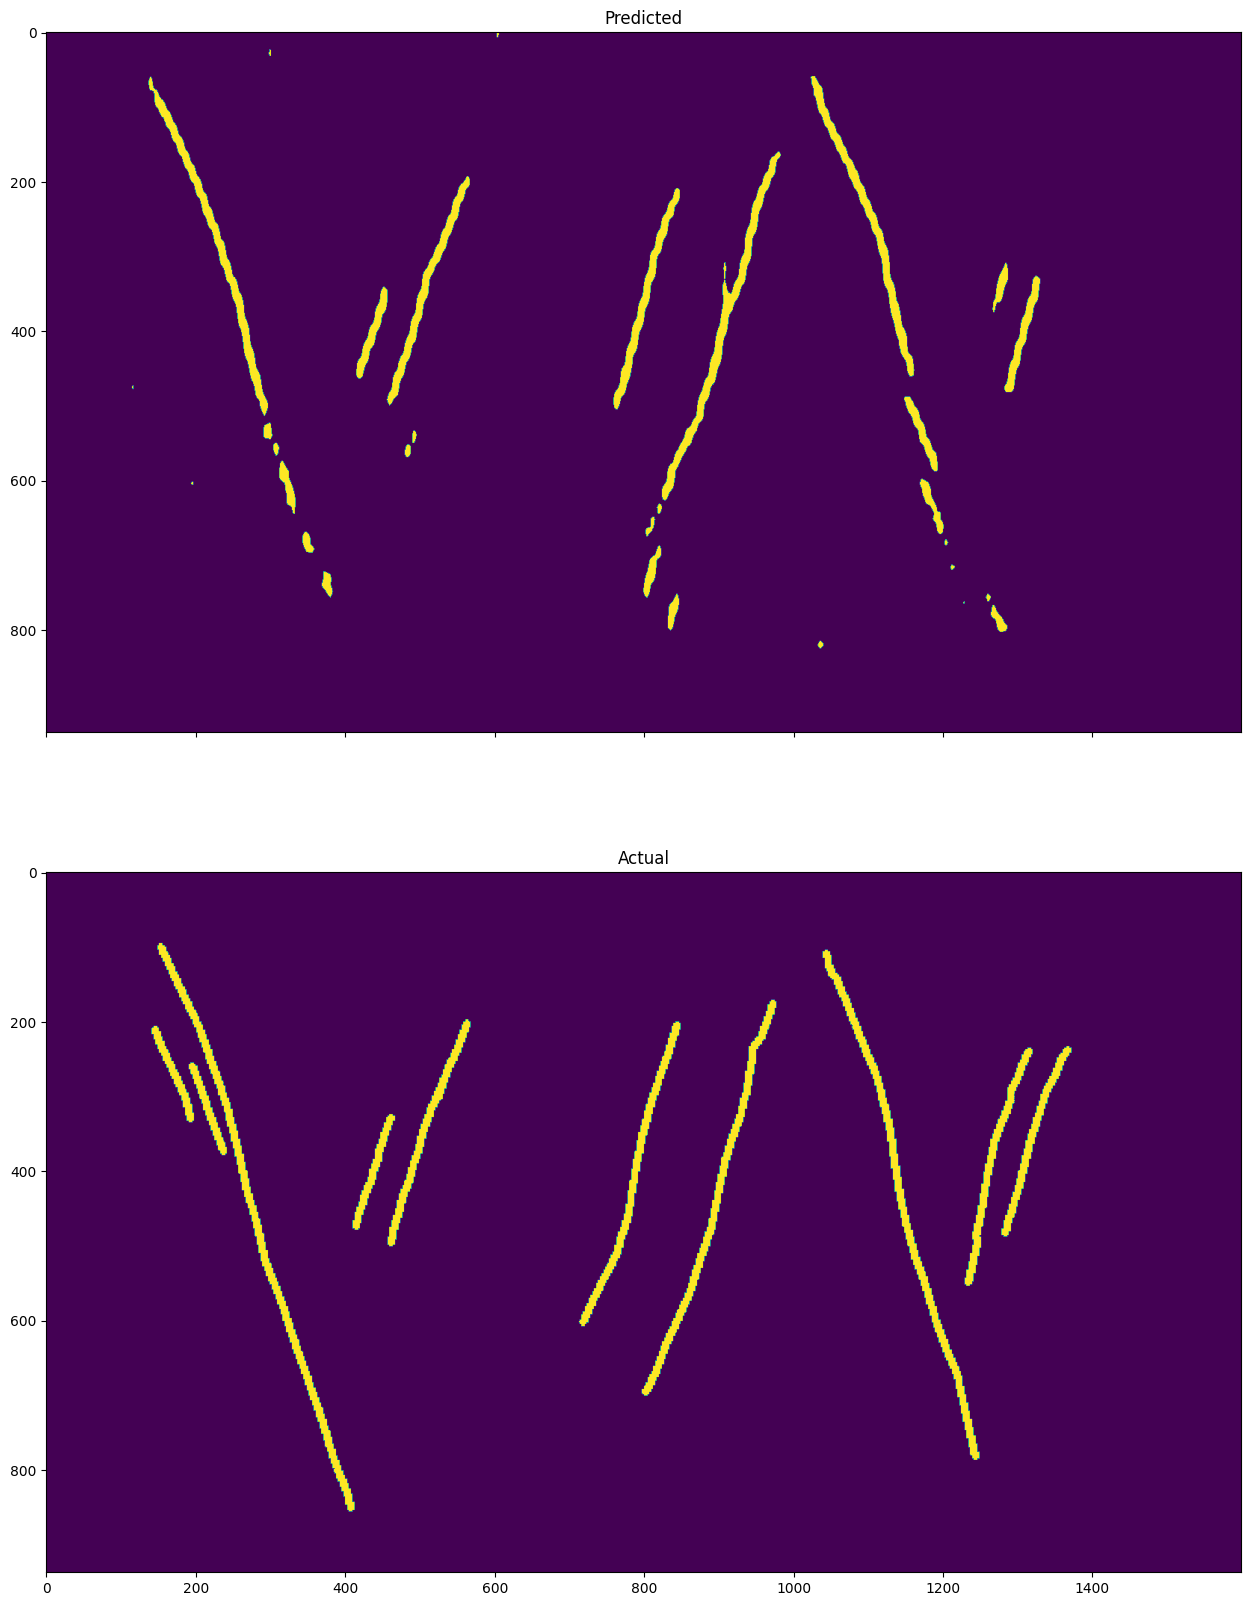

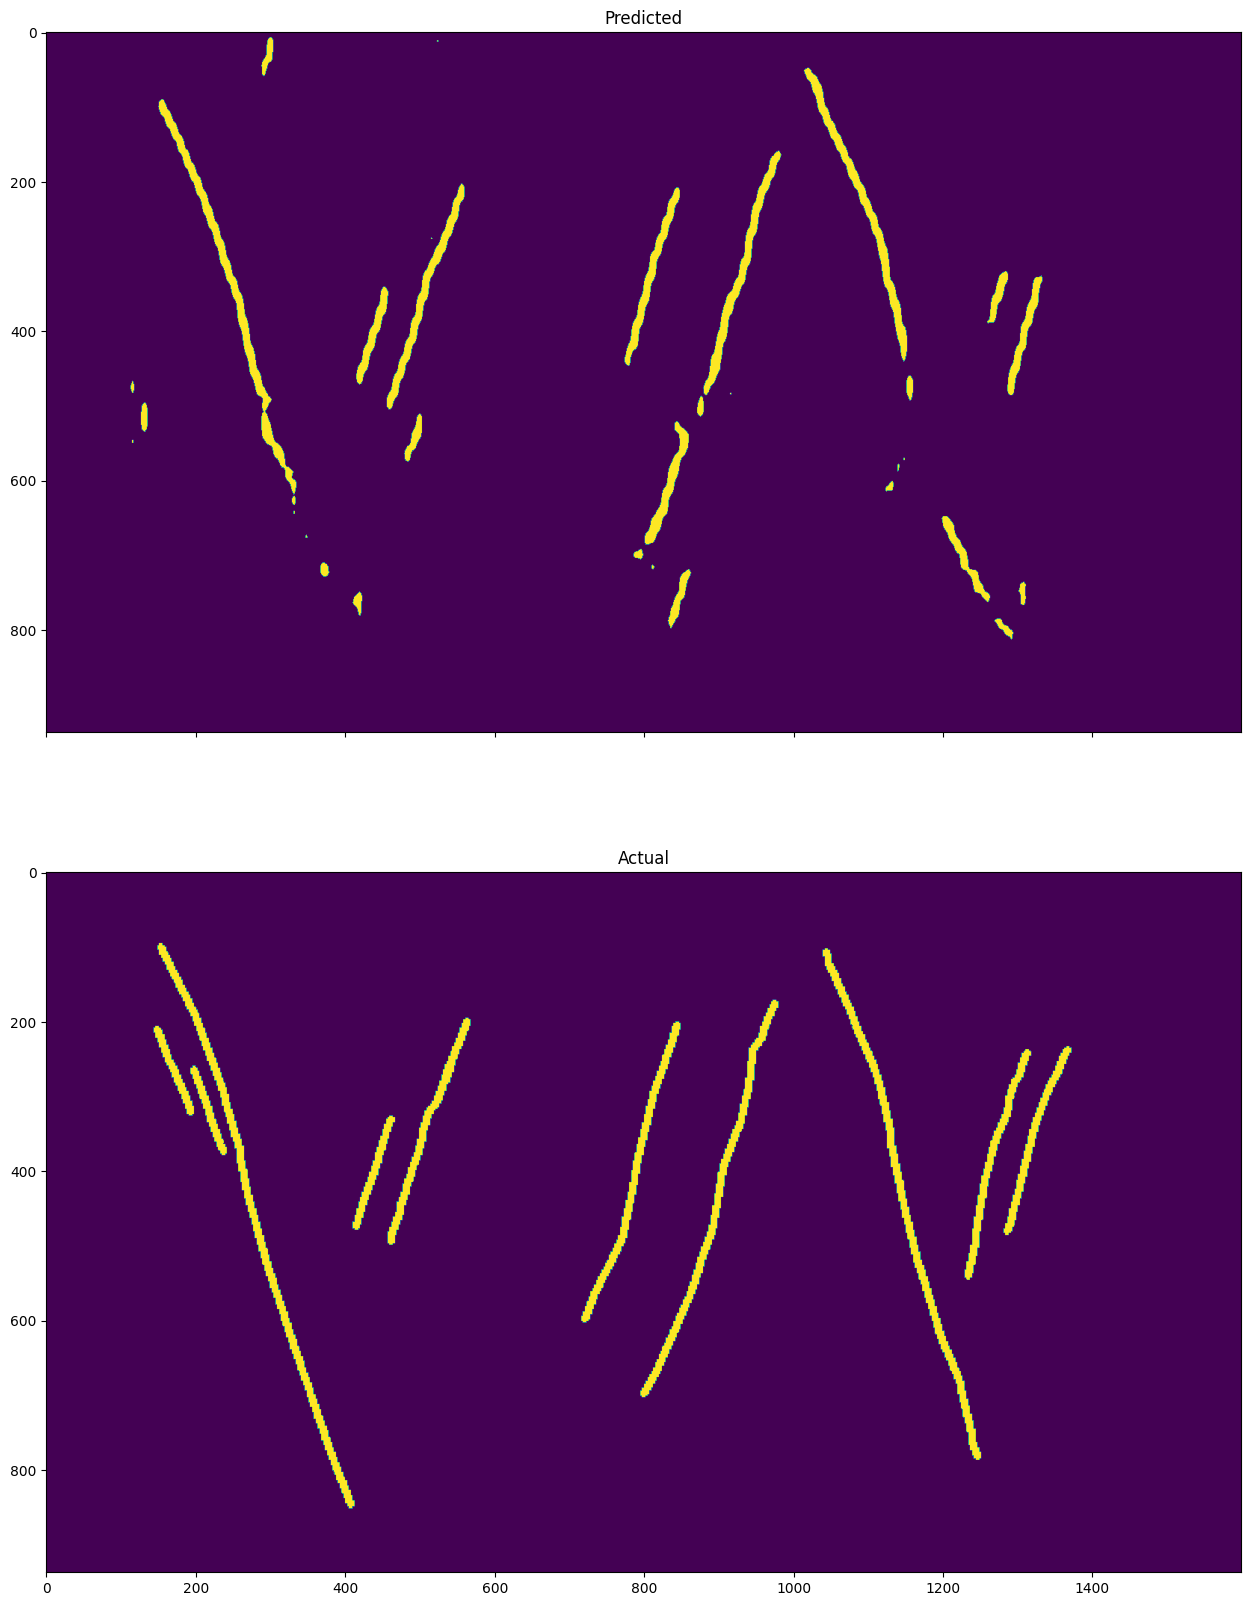

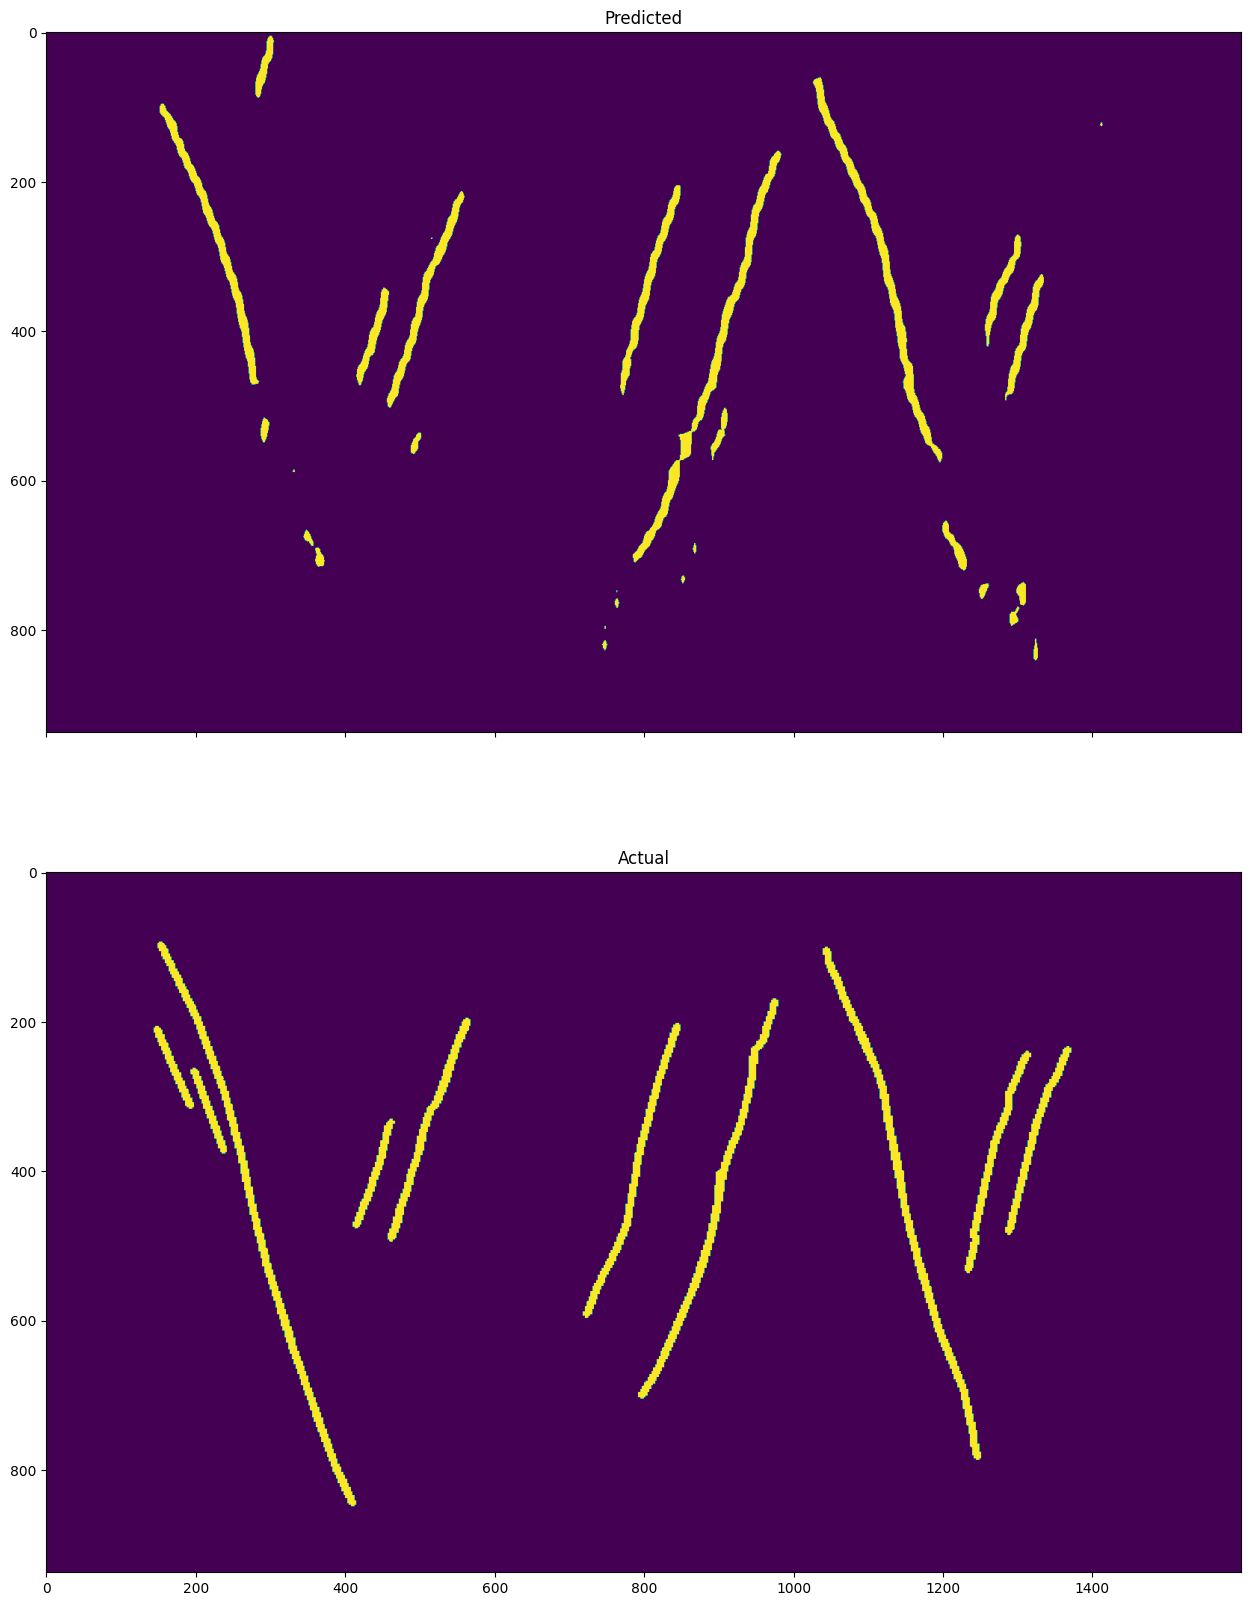

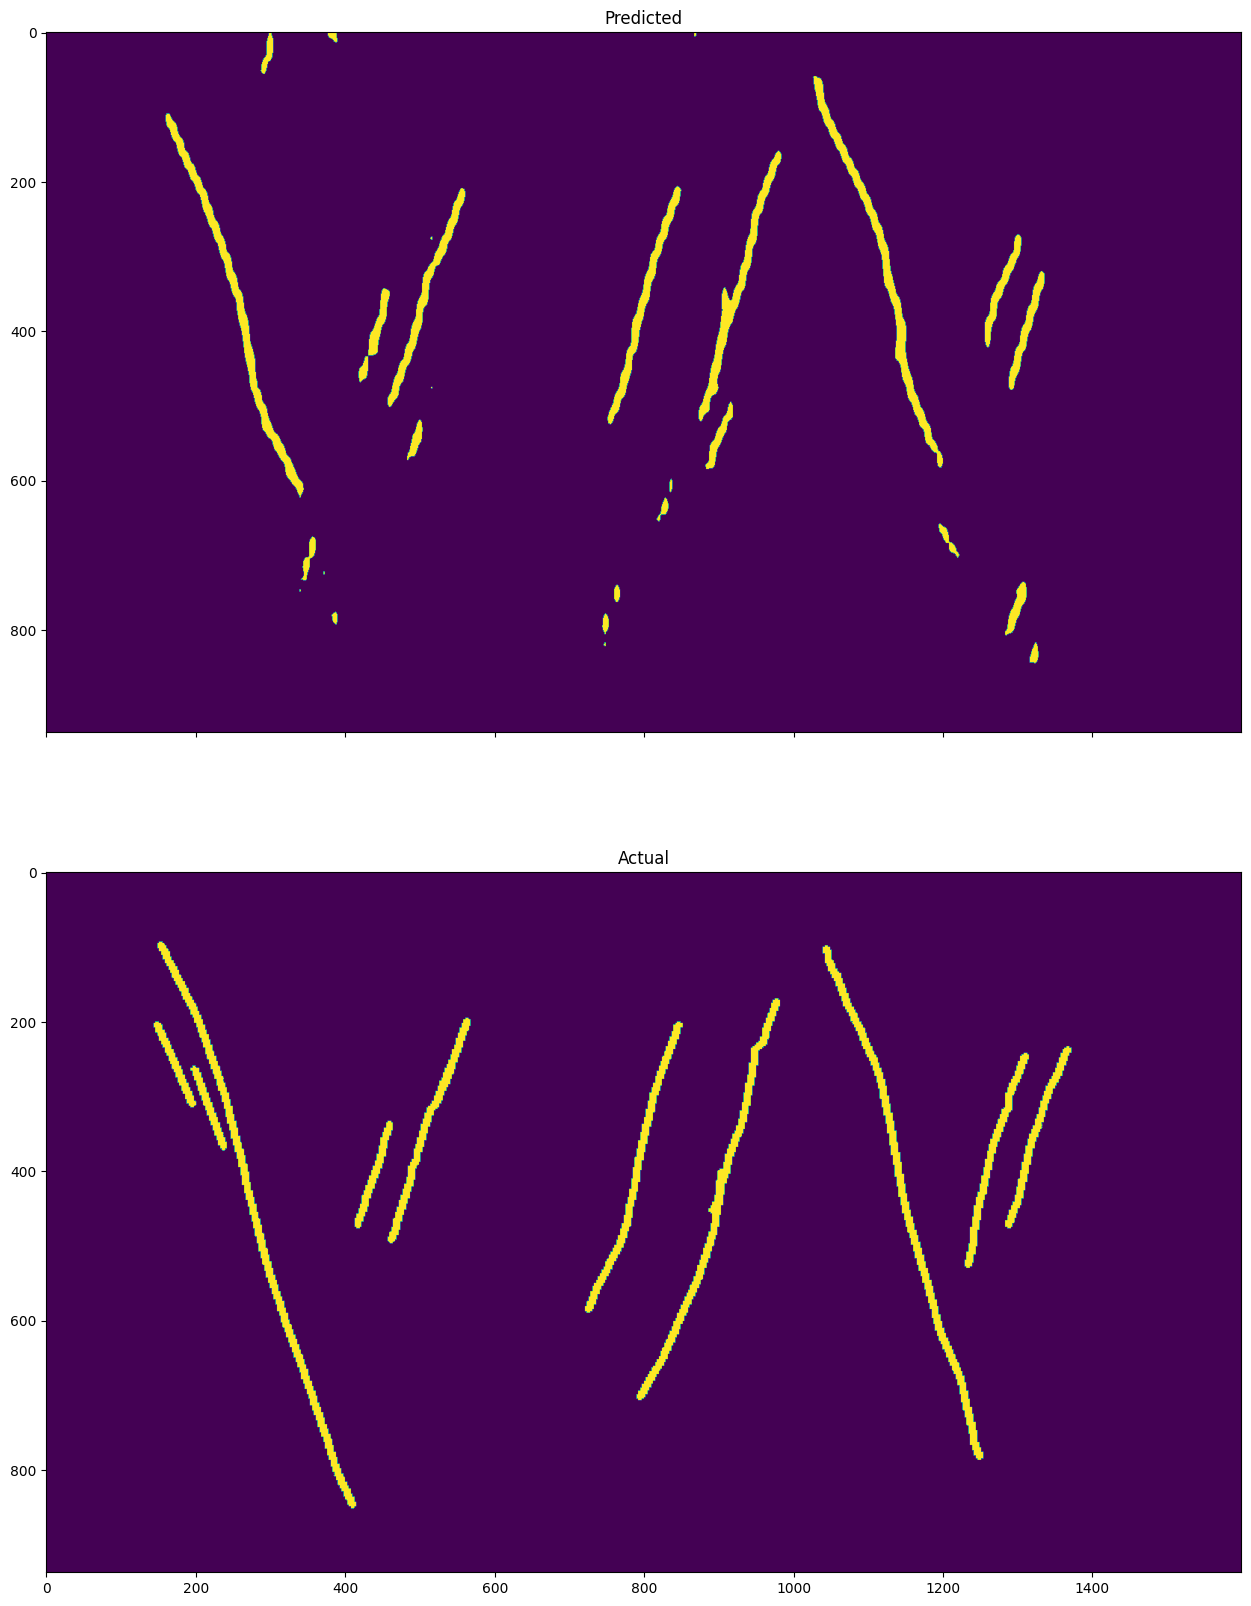

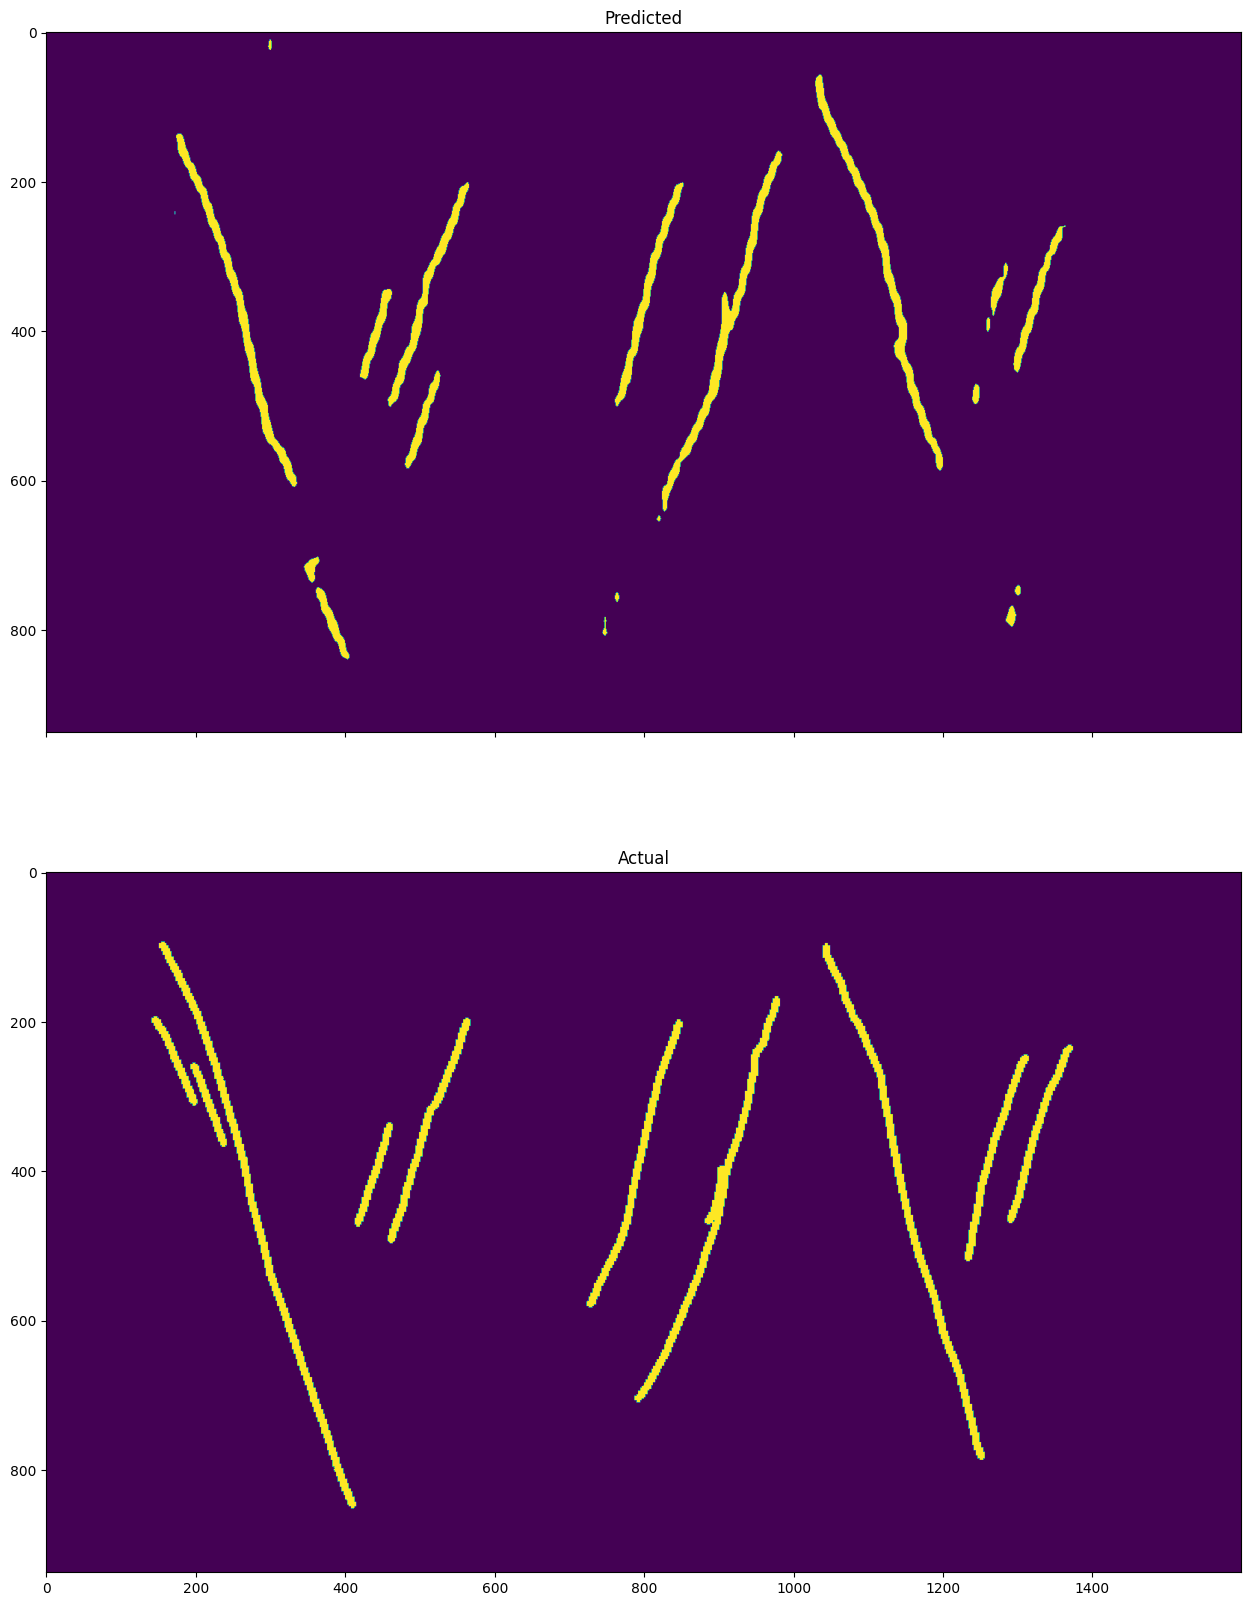

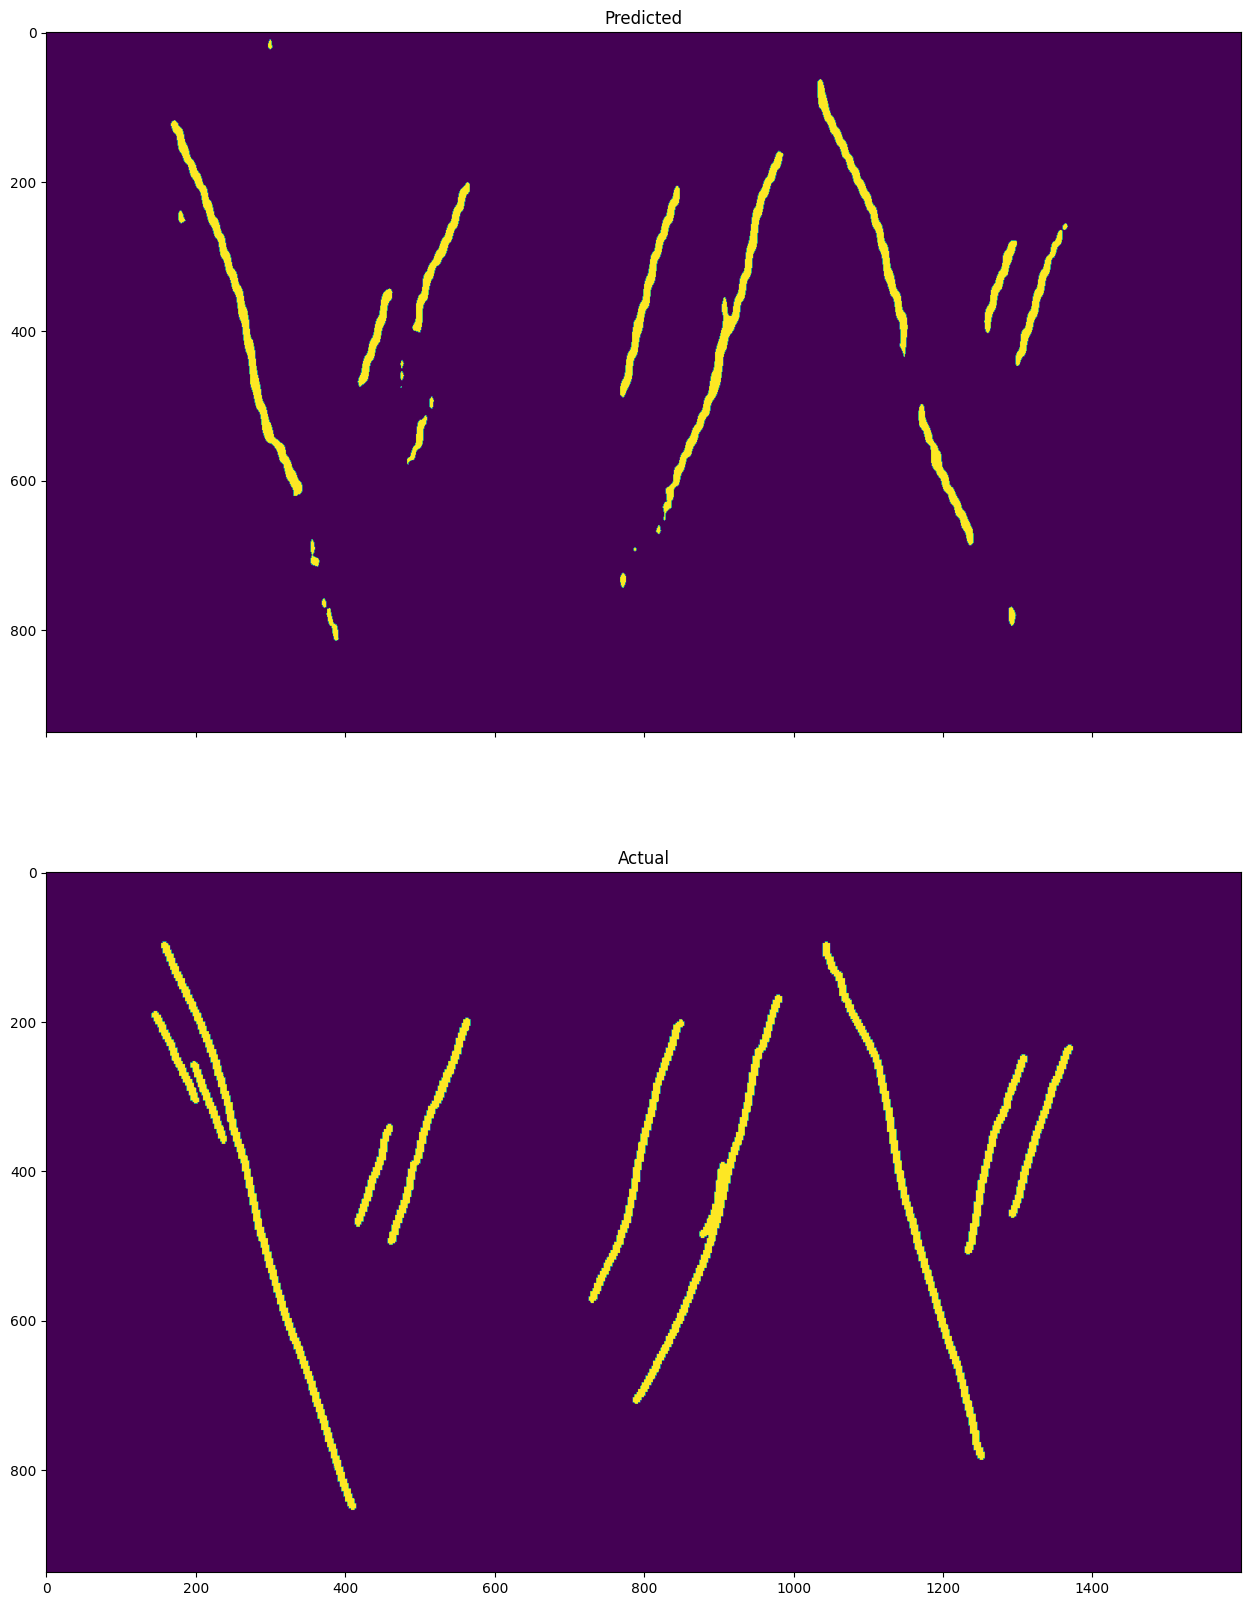

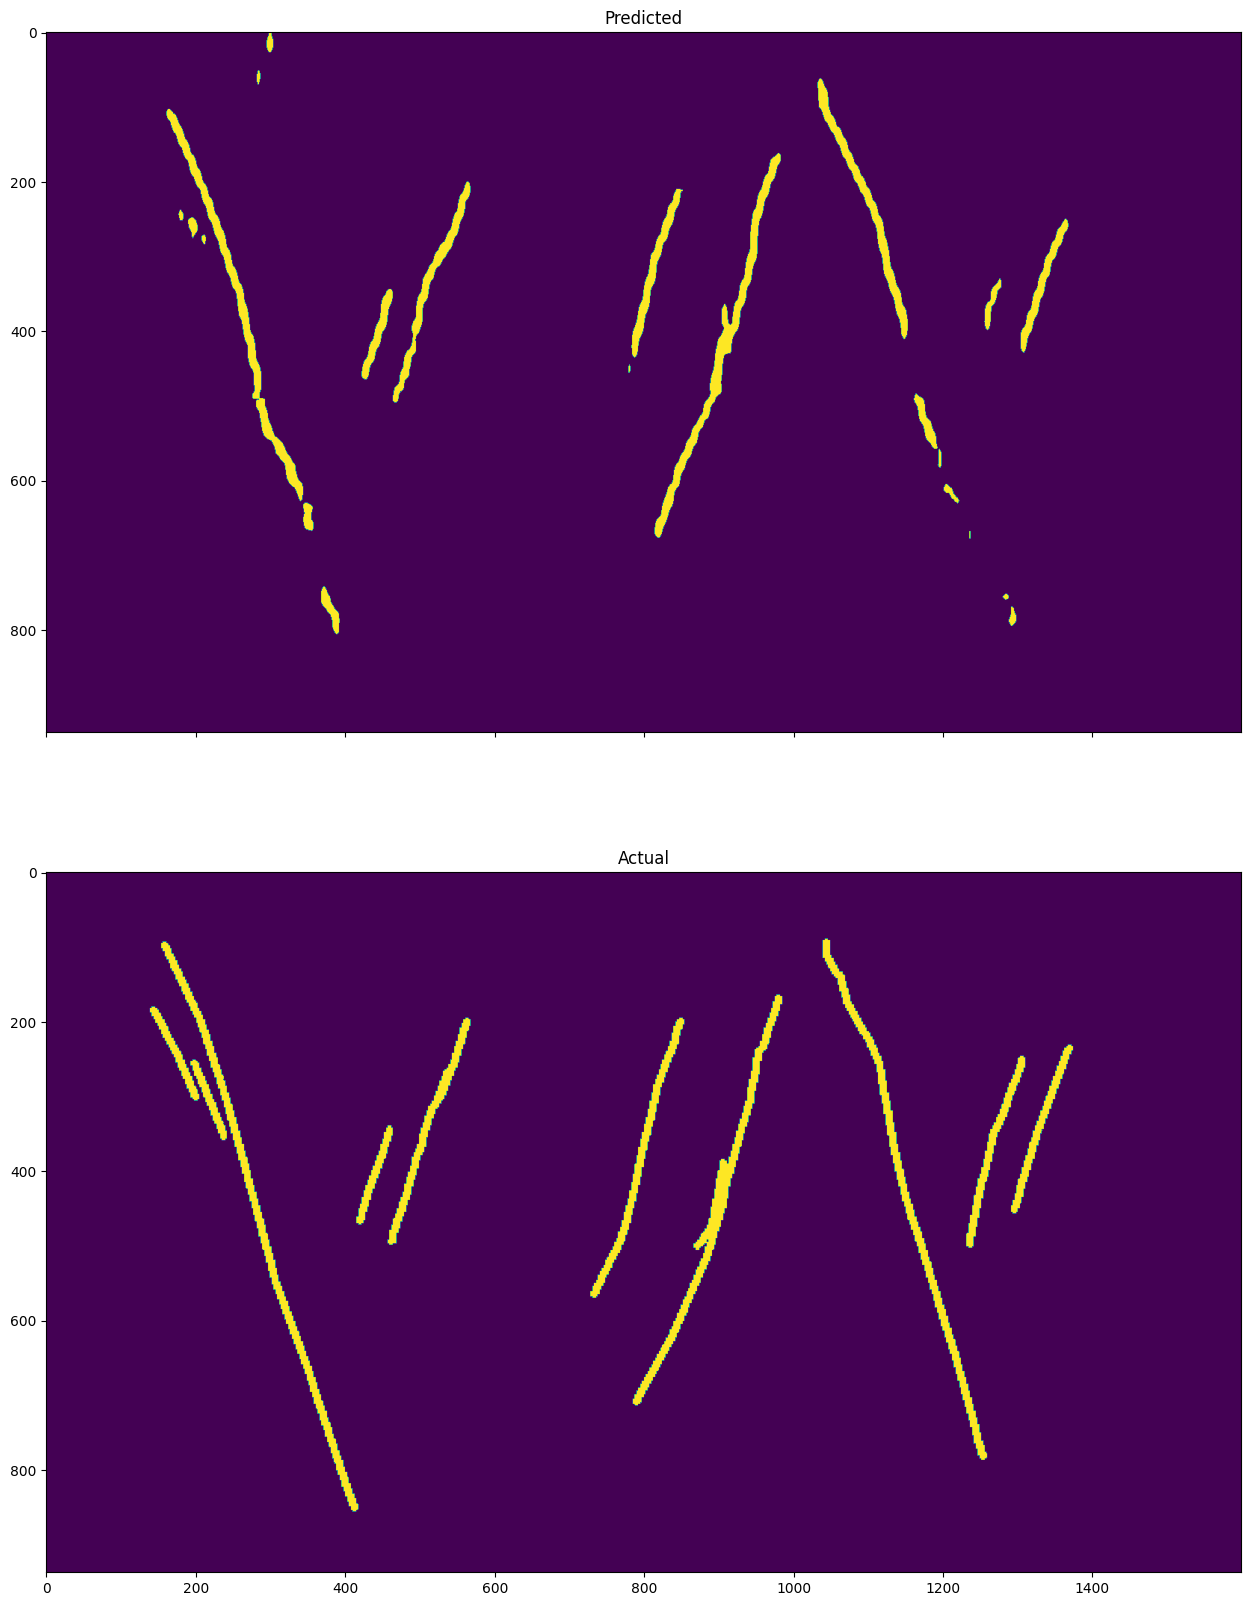

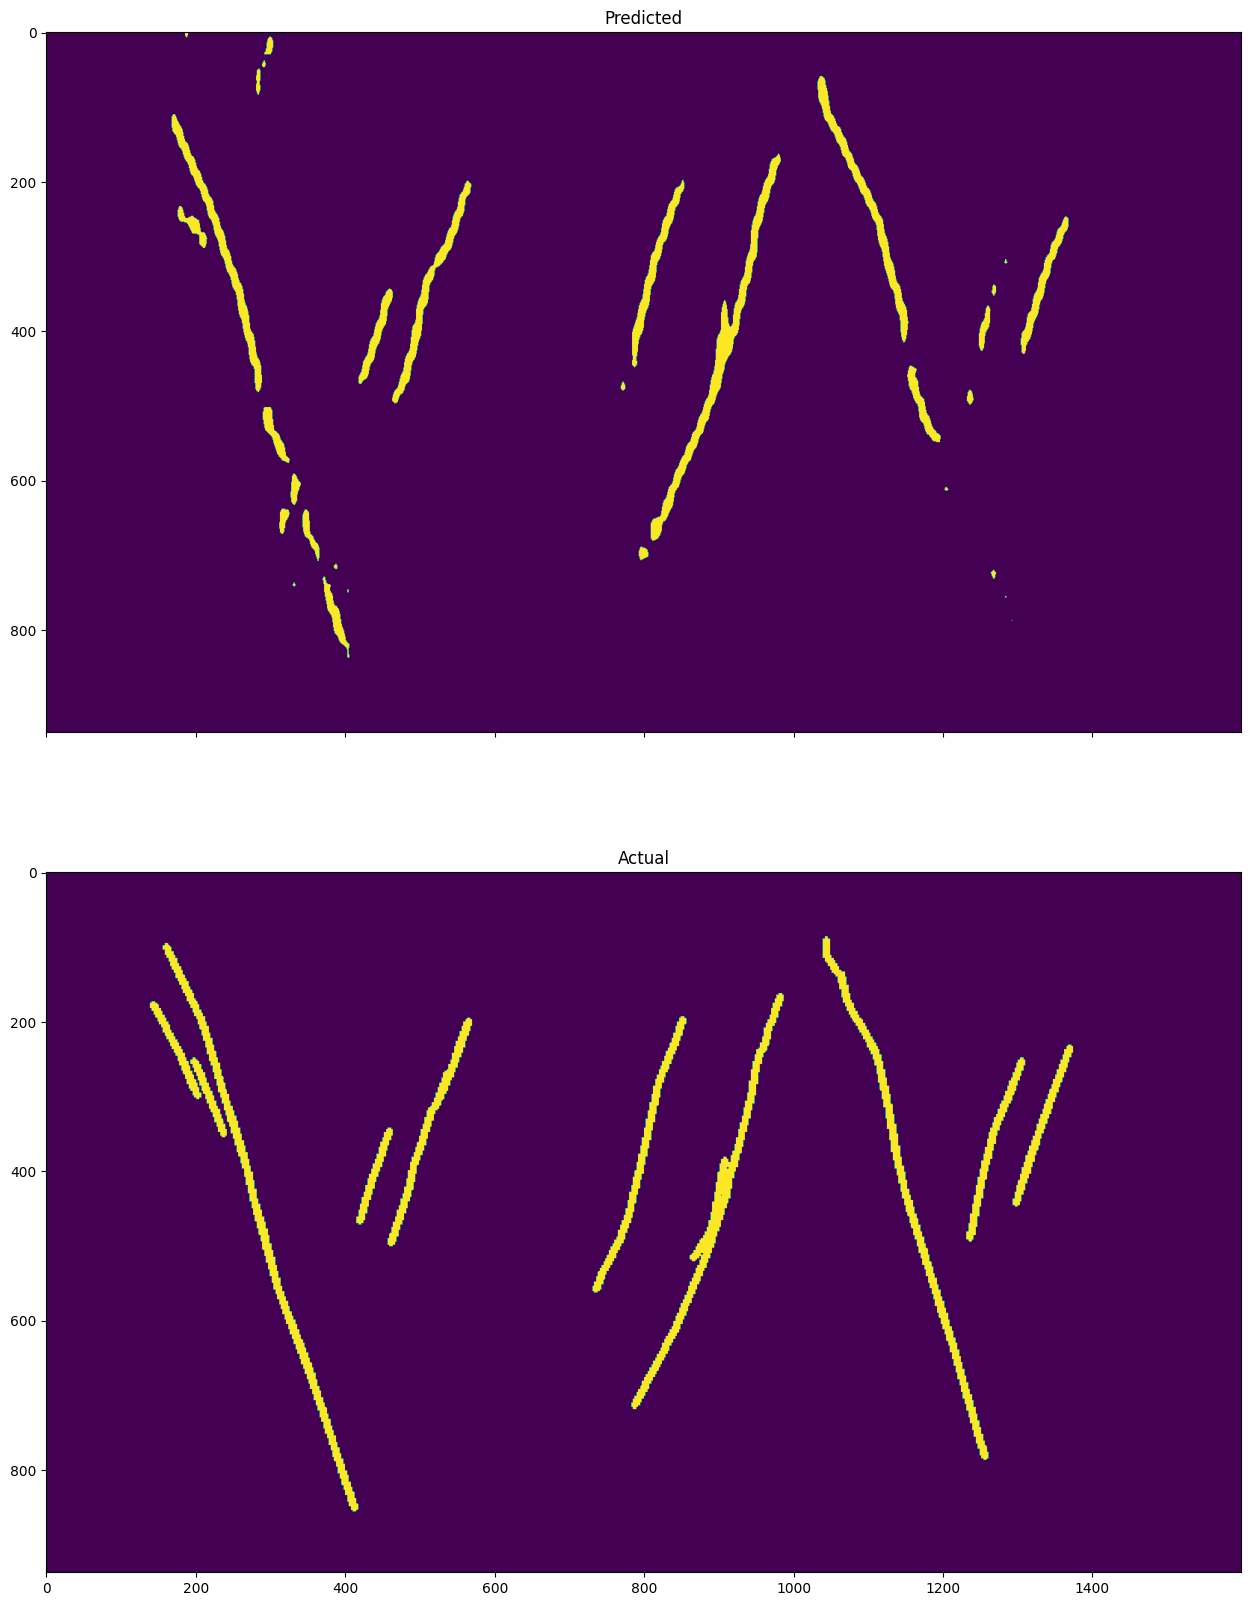

In [3]:
predict_horizon(network, "seistrain4.npz", "faulttrain4.npz", range(0, 11, 1), device, THRESHOLD, slicing=[600, None, 400, 2000], divisor=16)